# Jupyter Notebook: ged_analysis.ipynb

## 1. Import necessary libraries

In [1]:
import sys

!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install ipywidgets

import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
%matplotlib inline

# Now import ipywidgets
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


## 2. Define utility functions (for loading, cleaning, computing metrics)

In [2]:
def load_approx_results(file_path, fill_n_density=None):
    df = pd.read_excel(file_path)
    df.dropna(how='all', inplace=True)

    # Convert graph IDs to string to ensure consistent dtype
    df['graph_id_1'] = df['graph_id_1'].astype(str)
    df['graph_id_2'] = df['graph_id_2'].astype(str)

    numeric_cols = [
        'ged', 'accuracy', 'absolute_error', 'squared_error',
        'runtime', 'memory_usage_mb',
        'graph1_n', 'graph1_density', 'graph2_n', 'graph2_density'
    ]
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    if fill_n_density is not None:
        # Ensure fill DataFrame also has string-based IDs
        fill_n_density['graph_id_1'] = fill_n_density['graph_id_1'].astype(str)
        fill_n_density['graph_id_2'] = fill_n_density['graph_id_2'].astype(str)

        needed_cols = ['graph1_n', 'graph2_n', 'graph1_density', 'graph2_density']
        ref_cols = ['graph_id_1', 'graph_id_2'] + needed_cols
        ref = fill_n_density[ref_cols].drop_duplicates()

        merged = pd.merge(
            df, ref,
            how='left',
            on=['graph_id_1','graph_id_2'],
            suffixes=('', '_ref')
        )
        for c in needed_cols:
            merged[c] = np.where(
                merged[c].isna(),
                merged[f"{c}_ref"],
                merged[c]
            )
        drop_cols = [f"{c}_ref" for c in needed_cols if f"{c}_ref" in merged.columns]
        merged.drop(columns=drop_cols, inplace=True)
        df = merged

    df.dropna(subset=['graph_id_1','graph_id_2'], inplace=True)
    return df

def load_exact_results(file_path):
    """
    Load exact GED results from an XLSX file.
    Compute 'ged_exact' as the median of (min_ged, max_ged) if they differ,
    else min_ged (or max_ged).
    """
    df = pd.read_excel(file_path)
    df.dropna(how='all', inplace=True)

    # Convert graph IDs to string
    df['graph_id_1'] = df['graph_id_1'].astype(str)
    df['graph_id_2'] = df['graph_id_2'].astype(str)

    for col in ['min_ged', 'max_ged']:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    def compute_ged_exact(row):
        if pd.notnull(row['min_ged']) and pd.notnull(row['max_ged']) and row['min_ged'] != row['max_ged']:
            return (row['min_ged'] + row['max_ged']) / 2.0
        else:
            return row['min_ged']  # or row['max_ged']

    df['ged_exact'] = df.apply(compute_ged_exact, axis=1)
    df.dropna(subset=['graph_id_1','graph_id_2','ged_exact'], inplace=True)
    return df

def compute_relative_accuracy(ged_approx, ged_exact):
    if ged_exact == 0 or ged_approx is None or ged_exact is None:
        return np.nan
    elif ged_approx >= (ged_exact * 2):
        return 0
    return 1 - abs(ged_approx - ged_exact)/ged_exact

## 3. Define file paths for each dataset & method

In [3]:
datasets = {
    "AIDS": {
        "HED":      r"C:\project_data\results\gedlib\AIDS\AIDS_HED_results.xlsx",
        "IPFP":     r"C:\project_data\results\gedlib\AIDS\AIDS_IPFP_results.xlsx",
        "SimGNN":   r"C:\project_data\results\neural\AIDS\performance.xlsx",
        "Exact":    r"C:\project_data\results\exact_ged\AIDS\merged\results.xlsx"
    },
    "IMDB-BINARY": {
        "HED":      r"C:\project_data\results\gedlib\IMDB-BINARY\IMDB-BINARY_HED_results.xlsx",
        "IPFP":     r"C:\project_data\results\gedlib\IMDB-BINARY\IMDB-BINARY_IPFP_results.xlsx",
        "SimGNN":   r"C:\project_data\results\neural\IMDB-BINARY\performance.xlsx",
        "Exact":    r"C:\project_data\results\exact_ged\IMDB-BINARY\merged\results.xlsx"
    },
    "PROTEINS": {
        "HED":      r"C:\project_data\results\gedlib\PROTEINS\PROTEINS_HED_results.xlsx",
        "IPFP":     r"C:\project_data\results\gedlib\PROTEINS\PROTEINS_IPFP_results.xlsx",
        "SimGNN":   r"C:\project_data\results\neural\PROTEINS\performance.xlsx",
        "Exact":    r"C:\project_data\results\exact_ged\PROTEINS\merged\results.xlsx"
    }
}

## 4. Load data for each dataset & method

In [4]:
def adjust_ids(df):
    # Convert id columns to integer, add one, then back to string
    for col in ['graph_id_1', 'graph_id_2']:
        df[col] = df[col].astype(int) - 1
        df[col] = df[col].astype(str)
    return df

data = {}

for dset, paths in datasets.items():
    df_simgnn = load_approx_results(paths["SimGNN"])
    df_exact  = load_exact_results(paths["Exact"])

    df_hed  = load_approx_results(paths["HED"], fill_n_density=df_simgnn)
    df_ipfp = load_approx_results(paths["IPFP"], fill_n_density=df_simgnn)

    # Adjust ids for HED and IPFP so that they start from 1.
    df_exact_copy = df_exact.copy()
    df_exact = adjust_ids(df_exact)

    # For consistency, fill SimGNN from itself:
    df_simgnn_filled = load_approx_results(paths["SimGNN"], fill_n_density=df_simgnn)

    # Merge approximate with exact (intersection in memory)
    df_hed  = pd.merge(df_hed,  df_exact, on=['graph_id_1','graph_id_2'], how='inner', suffixes=('', '_exact'))
    df_ipfp = pd.merge(df_ipfp, df_exact, on=['graph_id_1','graph_id_2'], how='inner', suffixes=('', '_exact'))
    df_simgnn_filled = pd.merge(df_simgnn_filled, df_exact_copy, on=['graph_id_1','graph_id_2'], how='inner', suffixes=('', '_exact'))

    # Compute metrics
    for df_approx in [df_hed, df_ipfp, df_simgnn_filled]:
        if 'ged_exact' in df_approx.columns and 'ged' in df_approx.columns:
            df_approx['absolute_error'] = abs(df_approx['ged'] - df_approx['ged_exact'])
            df_approx['squared_error']  = (df_approx['ged'] - df_approx['ged_exact'])**2
            df_approx['accuracy'] = df_approx.apply(
                lambda row: compute_relative_accuracy(row['ged'], row['ged_exact'])
                            if pd.notnull(row['ged_exact']) else np.nan,
                axis=1
            )
            df_approx['graph_size'] = (df_approx['graph1_n'] + df_approx['graph2_n']) / 2.0
            df_approx['graph_density'] = (df_approx['graph1_density'] + df_approx['graph2_density']) / 2.0

    data[dset] = {
        "HED":    df_hed,
        "IPFP":   df_ipfp,
        "SimGNN": df_simgnn_filled,
        "Exact": df_exact
    }

## 5. Generate correlation plots for each dataset

In [5]:
from scipy.stats import gaussian_kde

def filter_valid_accuracy(df):
    """
    Example helper to keep only rows with accuracy > 0 (if desired).
    If you want all rows (including zero or negative?), remove this filter.
    """
    return df[df['accuracy'] > 0]

def filter_common_pairs(dset):
    """
    Returns a dictionary with filtered DataFrames for each method (HED, IPFP, SimGNN)
    containing only the common graph pairs (i.e. rows where (graph_id_1, graph_id_2) appear in all three methods).
    """
    methods = ["HED", "IPFP", "SimGNN"]
    common_pairs = None
    for method in methods:
        df_method = data[dset][method]
        pairs = set(zip(df_method["graph_id_1"], df_method["graph_id_2"]))
        if common_pairs is None:
            common_pairs = pairs
        else:
            common_pairs = common_pairs.intersection(pairs)
    filtered = {}
    for method in methods:
        df_method = data[dset][method]
        filtered[method] = df_method[df_method.apply(lambda row: (row["graph_id_1"], row["graph_id_2"]) in common_pairs, axis=1)]
    return filtered


## Function to Plot Accuracy Density by Graph Size for Each Method

In [6]:
import pandas as pd

def get_df_with_simgnn_size(dset, method):
    # Retrieve the data for the chosen method
    df_method = data[dset][method].copy()
    # Retrieve SimGNN data that contains graph_size values
    df_simgnn = data[dset]["SimGNN"][["graph_id_1", "graph_id_2", "graph_size"]]
    # Merge the two DataFrames on 'graph_id_1' and 'graph_id_2'
    df_merged = pd.merge(df_method, df_simgnn,
                         on=["graph_id_1", "graph_id_2"],
                         how="left",
                         suffixes=("", "_simgnn"))
    # Replace the 'graph_size' from the original with the SimGNN's value
    df_merged["graph_size"] = df_merged["graph_size_simgnn"]
    return df_merged

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import pandas as pd

def plot_accuracy_hist_by_size_per_algorithm(dset):
    """
    For the given dataset name dset, create one figure per algorithm (HED, IPFP, SimGNN)
    showing the accuracy density curves for three graph size categories: Low Size, Medium Size and Large Size.
    The categories are determined by splitting the range of graph_size into three equal-width bins.
    """
    methods = ["HED", "IPFP", "SimGNN"]
    colors = {"Low Size": "blue", "Medium Size": "orange", "Large Size": "red"}
    labels_order = ["Low Size", "Medium Size", "Large Size"]

    for method in methods:
        # Merge method data with SimGNN graph_size values and filter valid rows
        df_method = get_df_with_simgnn_size(dset, method)
        df_valid = filter_valid_accuracy(df_method)
        if df_valid.empty:
            continue

        # Determine min and max of graph sizes and split into 3 equal-width bins
        size_min = df_valid["graph_size"].min()
        size_max = df_valid["graph_size"].max()
        bins = np.linspace(size_min, size_max, 4)
        df_valid["size_category"] = pd.cut(df_valid["graph_size"], bins=bins, labels=labels_order, include_lowest=True)

        # Create figure for the current algorithm
        fig, ax = plt.subplots(figsize=(8, 4), dpi=120)

        # Plot density for each graph size category on the same ax
        for cat in labels_order:
            df_cat = df_valid[df_valid["size_category"] == cat]
            if df_cat.empty:
                continue

            accuracy_series = df_cat["accuracy"]
            median_val = accuracy_series.median()

            # Compute density curve using gaussian_kde; handle case where values are constant
            try:
                if accuracy_series.nunique() == 1 or accuracy_series.std() == 0:
                    const_val = accuracy_series.iloc[0]
                    x_range = np.linspace(const_val - 1e-3, const_val + 1e-3, 100)
                    y = np.exp(-((x_range - const_val) ** 2) / (2 * 1e-6))
                    y = y / y.max()
                else:
                    x_min, x_max = accuracy_series.min(), accuracy_series.max()
                    x_range = np.linspace(x_min, x_max, 100)
                    kde = gaussian_kde(accuracy_series)
                    y = kde(x_range)
            except np.linalg.LinAlgError:
                accuracy_series_noisy = accuracy_series + np.random.normal(0, 1e-3, size=len(accuracy_series))
                kde = gaussian_kde(accuracy_series_noisy)
                y = kde(x_range)

            label_text = f"{cat} (Median = {median_val:.2f})"
            ax.plot(x_range, y, label=label_text, color=colors[cat])
            ax.fill_between(x_range, y, alpha=0.3, color=colors[cat])

        ax.set_title(f"{dset} \u2014 {method}: Accuracy KDE by Graph Size")
        ax.set_xlabel("Accuracy")
        ax.set_xlim(0, 1)
        ax.set_ylabel("Probability Density (KDE)")
        ax.legend()
        ax.grid(True)
        plt.tight_layout()
        plt.show()

C:\Users\mikef\AppData\Local\Temp\ipykernel_6988\2435190323.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid["size_category"] = pd.cut(df_valid["graph_size"], bins=bins, labels=labels_order, include_lowest=True)


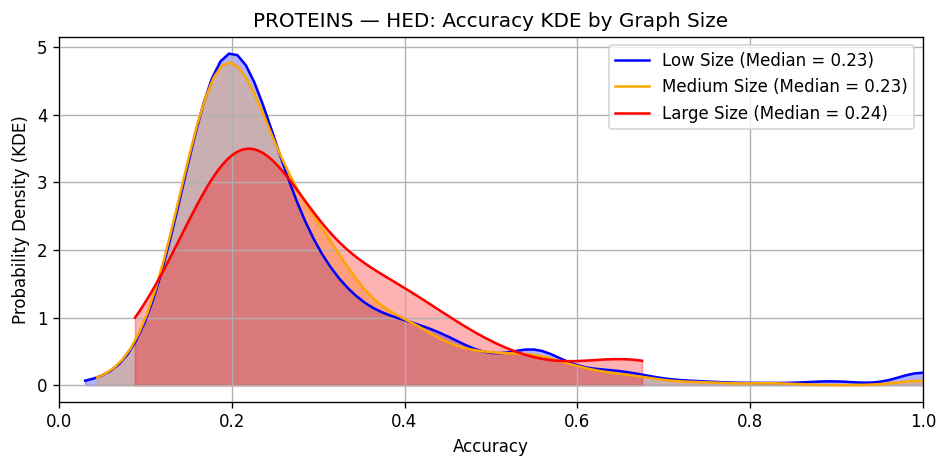

C:\Users\mikef\AppData\Local\Temp\ipykernel_6988\2435190323.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid["size_category"] = pd.cut(df_valid["graph_size"], bins=bins, labels=labels_order, include_lowest=True)


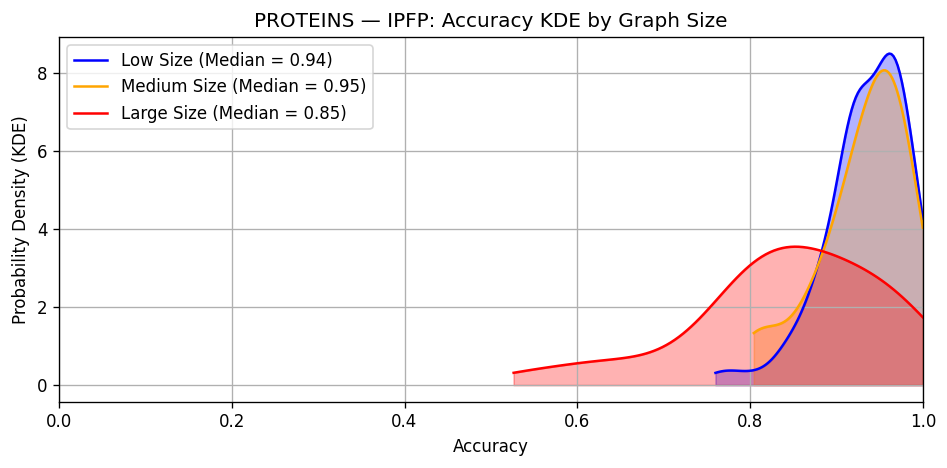

C:\Users\mikef\AppData\Local\Temp\ipykernel_6988\2435190323.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid["size_category"] = pd.cut(df_valid["graph_size"], bins=bins, labels=labels_order, include_lowest=True)


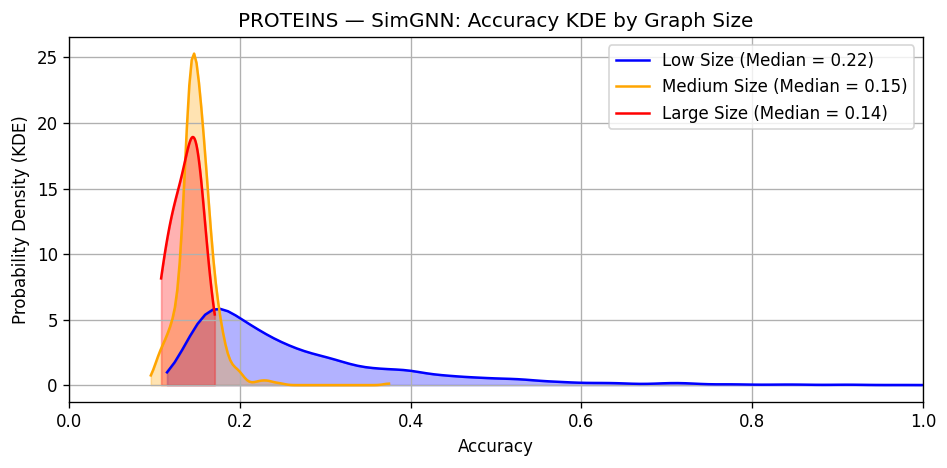

In [69]:
plot_accuracy_hist_by_size_per_algorithm(dset="PROTEINS")

## Function to Plot Accuracy Density by Graph Density for Each Method

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import pandas as pd

def plot_accuracy_hist_by_density_together(dset, density_threshold):
    """
    For the chosen dataset dset, create one figure per algorithm (HED, IPFP, SimGNN)
    where the accuracy density curves of two graph-density categories (Sparse and Dense)
    are plotted together.

    Sparse:  graph_density < density_threshold
    Dense:   graph_density ≥ density_threshold

    HED and IPFP retrieve graph_density from SimGNN by merging on (graph_id_1, graph_id_2).
    """
    methods = ["HED", "IPFP", "SimGNN"]
    # Colors for the two density categories
    cat_colors = {"Sparse": "blue", "Dense": "orange"}

    # Density categories: (Name, filter function)
    categories = [
        ("Sparse", lambda df: df["graph_density"] < density_threshold),
        ("Dense",  lambda df: df["graph_density"] >= density_threshold)
    ]

    def get_df_with_simgnn_density(dset, method):
        # Retrieve the method's data
        df_method = data[dset][method].copy()
        # Retrieve SimGNN data with graph_density
        df_simgnn = data[dset]["SimGNN"][["graph_id_1", "graph_id_2", "graph_density"]]
        # Merge on graph_id_1 and graph_id_2 and replace graph_density with SimGNN's value
        df_merged = pd.merge(
            df_method, df_simgnn,
            on=["graph_id_1", "graph_id_2"],
            how="left",
            suffixes=("", "_simgnn")
        )
        df_merged["graph_density"] = df_merged["graph_density_simgnn"]
        return df_merged

    # Loop through each algorithm
    for method in methods:
        df_merged = get_df_with_simgnn_density(dset, method)
        df_valid = filter_valid_accuracy(df_merged)

        fig, ax = plt.subplots(figsize=(8, 4), dpi=120)

        # For each density category, filter the data and plot the density curve
        for cat_name, cat_filter in categories:
            df_cat = df_valid[cat_filter(df_valid)]
            if not df_cat.empty:
                accuracy_series = df_cat["accuracy"]
                median_val = accuracy_series.median()
                label = f"{cat_name} (median={median_val:.2f})"

                # Check for constant or nearly constant values
                if accuracy_series.nunique() == 1 or accuracy_series.std() == 0:
                    const_val = accuracy_series.iloc[0]
                    x_range = np.linspace(const_val - 1e-3, const_val + 1e-3, 100)
                    y = np.exp(-((x_range - const_val) ** 2) / (2 * (1e-6)))
                    y = y / y.max()
                    ax.plot(x_range, y, label=label, color=cat_colors[cat_name])
                    ax.fill_between(x_range, y, alpha=0.3, color=cat_colors[cat_name])
                else:
                    x_min, x_max = accuracy_series.min(), accuracy_series.max()
                    x_range = np.linspace(x_min, x_max, 100)
                    try:
                        kde = gaussian_kde(accuracy_series)
                        y = kde(x_range)
                    except np.linalg.LinAlgError:
                        # Fallback in case of singular covariance matrix error
                        data_series_noisy = accuracy_series + np.random.normal(0, 1e-3, size=len(accuracy_series))
                        kde = gaussian_kde(data_series_noisy)
                        y = kde(x_range)
                    ax.plot(x_range, y, label=label, color=cat_colors[cat_name])
                    ax.fill_between(x_range, y, alpha=0.3, color=cat_colors[cat_name])
            else:
                ax.text(0.5, 0.5, f"{cat_name}: No data", horizontalalignment="center",
                        verticalalignment="center", transform=ax.transAxes)

        ax.set_title(f"{dset} \u2014 {method}: Accuracy KDE by Graph Density")
        ax.set_xlabel("Accuracy")
        ax.set_xlim(0, 1)
        ax.set_ylabel("Probability Density (KDE)")
        ax.legend()
        ax.grid(True)
        plt.tight_layout()
        plt.show()

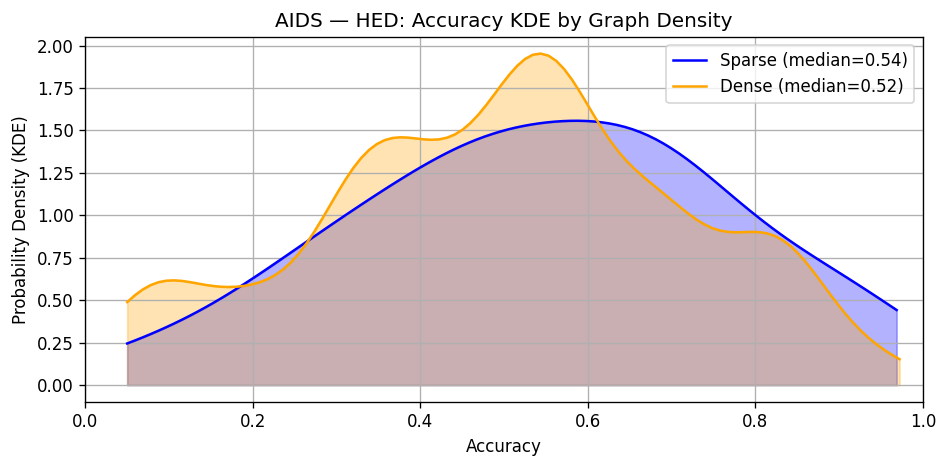

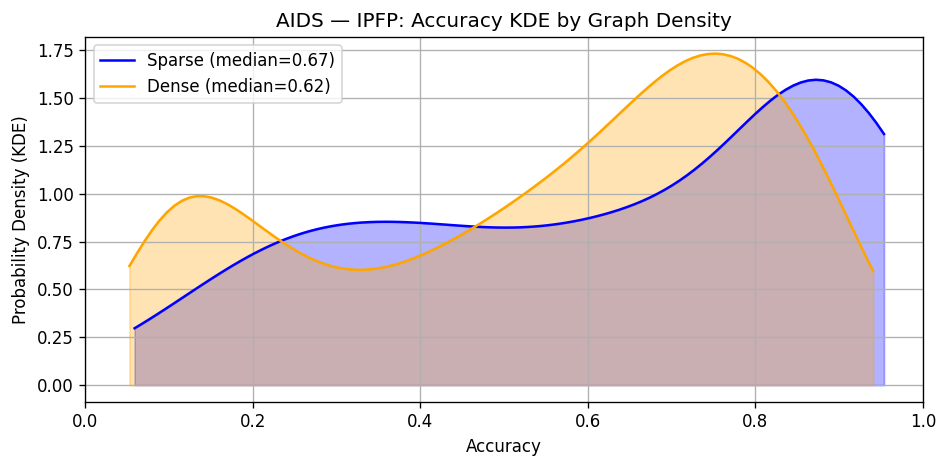

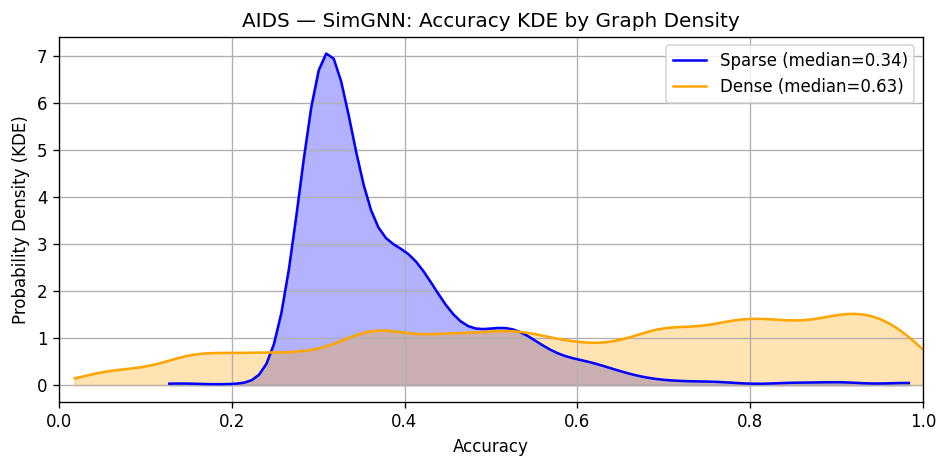

In [53]:
plot_accuracy_hist_by_density_together(dset="AIDS", density_threshold=0.15)

In [12]:
import os
import xml.etree.ElementTree as ET

def compute_graph_density(gxl_path):
    """
    Parses a GXL file and calculates its density.
    Density = 2 * E / (n * (n-1)) for an undirected graph.
    """
    try:
        tree = ET.parse(gxl_path)
        root = tree.getroot()
    except Exception as e:
        print(f"Error parsing {gxl_path}: {e}")
        return 0

    # Find the graph element
    graph_elem = root.find('graph')
    if graph_elem is None:
        print(f"No graph element found in {gxl_path}")
        return 0

    # Count nodes and edges
    nodes = graph_elem.findall('node')
    edges = graph_elem.findall('edge')
    n = len(nodes)
    e = len(edges)

    if n < 2:
        return 0
    density = 2 * e / (n * (n - 1))
    return density

def compute_pair_density(graph_id_1, graph_id_2, gxl_directory):
    """
    Given the ids of two graphs and the directory where the GXL files are stored,
    this function loads `graph_id_1.gxl` and `graph_id_2.gxl`, computes each individual
    density, and returns their mean.
    """
    path1 = os.path.join(gxl_directory, f"{graph_id_1}.gxl")
    path2 = os.path.join(gxl_directory, f"{graph_id_2}.gxl")

    density1 = compute_graph_density(path1)
    density2 = compute_graph_density(path2)

    mean_density = (density1 + density2) / 2.0
    return mean_density

In [15]:
import os
import xml.etree.ElementTree as ET

def compute_graph_size(gxl_path):
    """
    Parses a GXL file and calculates its size as a tuple.
    The size is defined by the number of unique nodes and edges.
    """
    try:
        tree = ET.parse(gxl_path)
        root = tree.getroot()
    except Exception as e:
        print(f"Error parsing {gxl_path}: {e}")
        return (0, 0)

    graph_elem = root.find('graph')
    if graph_elem is None:
        print(f"No graph element found in {gxl_path}")
        return (0, 0)

    # Using node 'id' attributes to ensure uniqueness
    node_ids = {node.get("id") for node in graph_elem.findall('node')}
    # For edges, simply count unique edge elements (could be modified if edges need further uniqueness criteria)
    edge_ids = set()
    for edge in graph_elem.findall('edge'):
        # Create a tuple of sorted 'from' and 'to' attributes for undirected uniqueness if available.
        src = edge.get("from")
        tgt = edge.get("to")
        if src is not None and tgt is not None:
            edge_ids.add(tuple(sorted((src, tgt))))
        else:
            edge_ids.add(edge)

    num_nodes = len(node_ids)
    num_edges = len(edge_ids)
    return num_nodes + num_edges

def compute_pair_size(graph_id_1, graph_id_2, gxl_directory):
    """
    Given the ids of two graphs and the directory where the GXL files are stored,
    this function loads `graph_id_1.gxl` and `graph_id_2.gxl`, computes each individual
    size (number of unique nodes and edges), and returns their mean as a tuple.
    """
    path1 = os.path.join(gxl_directory, f"{graph_id_1}.gxl")
    path2 = os.path.join(gxl_directory, f"{graph_id_2}.gxl")

    size1 = compute_graph_size(path1)
    size2 = compute_graph_size(path2)

    return (size1 + size2) / 2.0

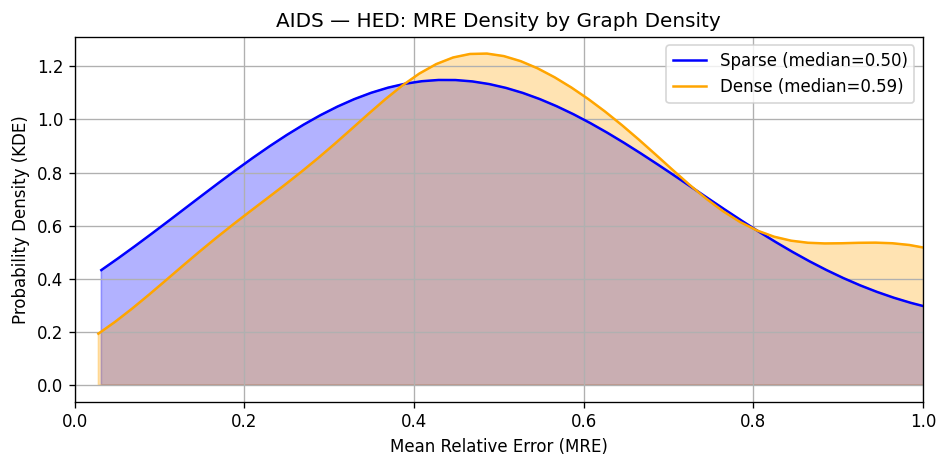

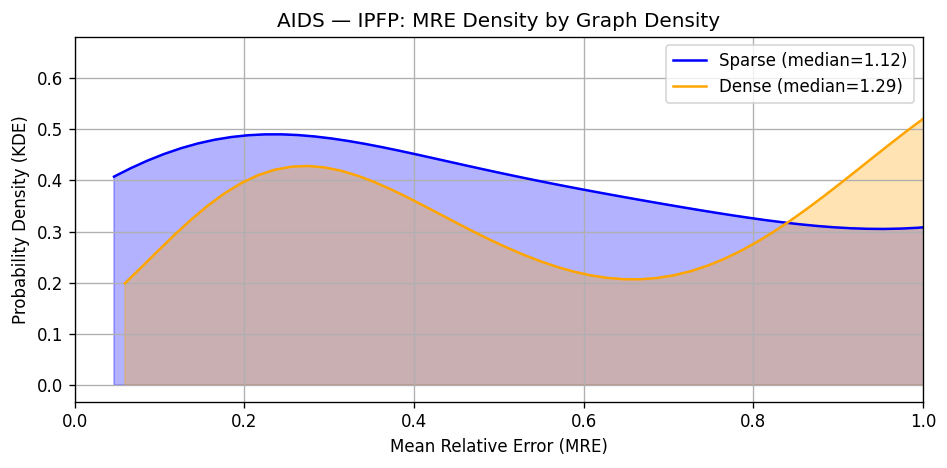

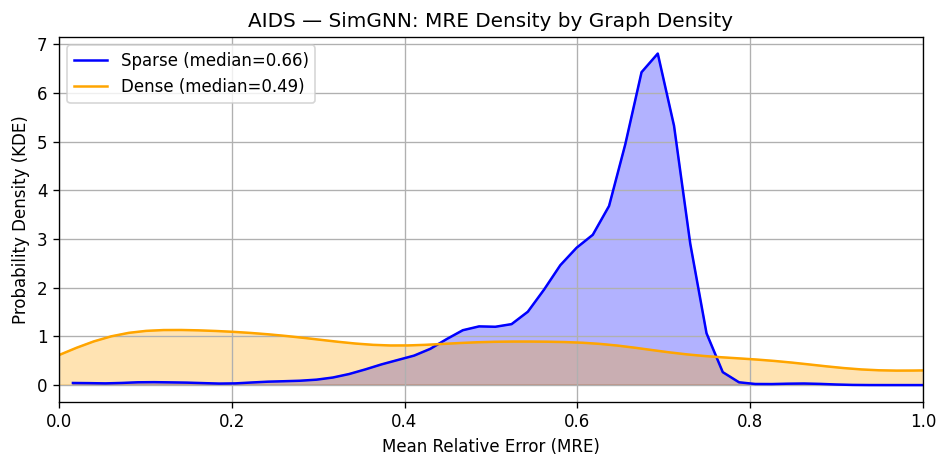

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import pandas as pd

def plot_mre_hist_by_density_together(dset, density_threshold):
    """
    For the chosen dataset dset, create one figure per algorithm (HED, IPFP, SimGNN)
    where the MRE (Mean Relative Error) density curves of two graph-density categories
    (Sparse and Dense) are plotted together.

    Sparse:  graph_density < density_threshold
    Dense:   graph_density ≥ density_threshold

    HED and IPFP retrieve graph_density from SimGNN by merging on (graph_id_1, graph_id_2).
    """
    methods = ["HED", "IPFP", "SimGNN"]
    # Colors for the two density categories
    cat_colors = {"Sparse": "blue", "Dense": "orange"}

    # Density categories: (Name, filter function)
    categories = [
        ("Sparse", lambda df: df["graph_density"] < density_threshold),
        ("Dense",  lambda df: df["graph_density"] >= density_threshold)
    ]

    def get_df_with_simgnn_density(dset, method):
        # Retrieve the method's data
        df_method = data[dset][method].copy()
        # Retrieve SimGNN data with graph_density
        df_simgnn = data[dset]["SimGNN"][["graph_id_1", "graph_id_2", "graph_density"]]
        # Merge on graph_id_1 and graph_id_2 and replace graph_density with SimGNN's value
        df_merged = pd.merge(
            df_method, df_simgnn,
            on=["graph_id_1", "graph_id_2"],
            how="left",
            suffixes=("", "_simgnn")
        )
        df_merged["graph_density"] = df_merged["graph_density_simgnn"]
        return df_merged

    # Loop through each algorithm
    for method in methods:
        df_merged = get_df_with_simgnn_density(dset, method)

        # Calculate MRE (Mean Relative Error)
        df_merged['mre'] = np.abs(df_merged['ged'] - df_merged['ged_exact']) / df_merged['ged_exact']

        # Filter valid MRE values (finite, non-NaN, and cap at reasonable value)
        df_valid = df_merged[np.isfinite(df_merged['mre'])]
        df_valid = df_valid[df_valid['mre'] <= 2.0]  # Cap at 200% error

        fig, ax = plt.subplots(figsize=(8, 4), dpi=120)

        # For each density category, filter the data and plot the density curve
        for cat_name, cat_filter in categories:
            df_cat = df_valid[cat_filter(df_valid)]
            if not df_cat.empty:
                mre_series = df_cat["mre"]
                median_val = mre_series.median()
                label = f"{cat_name} (median={median_val:.2f})"

                # Check for constant or nearly constant values
                if mre_series.nunique() == 1 or mre_series.std() == 0:
                    const_val = mre_series.iloc[0]
                    x_range = np.linspace(const_val - 1e-3, const_val + 1e-3, 100)
                    y = np.exp(-((x_range - const_val) ** 2) / (2 * (1e-6)))
                    y = y / y.max()
                    ax.plot(x_range, y, label=label, color=cat_colors[cat_name])
                    ax.fill_between(x_range, y, alpha=0.3, color=cat_colors[cat_name])
                else:
                    x_min, x_max = max(0, mre_series.min()), min(2.0, mre_series.max())
                    x_range = np.linspace(x_min, x_max, 100)
                    try:
                        kde = gaussian_kde(mre_series)
                        y = kde(x_range)
                    except np.linalg.LinAlgError:
                        # Fallback in case of singular covariance matrix error
                        data_series_noisy = mre_series + np.random.normal(0, 1e-3, size=len(mre_series))
                        kde = gaussian_kde(data_series_noisy)
                        y = kde(x_range)
                    ax.plot(x_range, y, label=label, color=cat_colors[cat_name])
                    ax.fill_between(x_range, y, alpha=0.3, color=cat_colors[cat_name])
            else:
                ax.text(0.5, 0.5, f"{cat_name}: No data", horizontalalignment="center",
                        verticalalignment="center", transform=ax.transAxes)

        ax.set_title(f"{dset} \u2014 {method}: MRE Density by Graph Density")
        ax.set_xlabel("Mean Relative Error (MRE)")
        ax.set_xlim(0, 1)  # Show up to 100% error
        ax.set_ylabel("Probability Density (KDE)")
        ax.legend()
        ax.grid(True)
        plt.tight_layout()
        plt.show()

plot_mre_hist_by_density_together("AIDS", 0.15)

In [17]:
import numpy as np
import pandas as pd

def calc_mean_graph_size_best_ipfp_accuracy(dset, gxl_directory):
    """
    For the given dataset dset, calculates the mean graph size for the cases where IPFP achieves its best accuracy.

    It first retrieves the IPFP data, computes the graph size for each row using compute_pair_size,
    filters valid accuracy entries using filter_valid_accuracy, and then calculates the mean graph size
    among all rows where the accuracy is equal to the best accuracy achieved.
    """
    # Retrieve IPFP data and compute graph sizes.
    df_ipfp = data[dset]["IPFP"].copy()
    df_ipfp["graph_size"] = df_ipfp.apply(
        lambda row: compute_pair_size(row["graph_id_1"], row["graph_id_2"], gxl_directory),
        axis=1
    )

    # Filter rows with valid accuracy values.
    df_valid = filter_valid_accuracy(df_ipfp)

    if df_valid.empty:
        return None

    # Determine the best accuracy value (assuming higher accuracy is better).
    best_accuracy = df_valid["accuracy"].max()

    # Filter rows where the accuracy equals the best value.
    best_df = df_valid[df_valid["accuracy"] == best_accuracy]

    # Compute and return the mean graph size for those cases.
    mean_graph_size = best_df["graph_size"].mean()
    return mean_graph_size

result = calc_mean_graph_size_best_ipfp_accuracy("AIDS", r"C:\project_data\processed_data\gxl\AIDS")
print("Mean graph size for best IPFP accuracy:", result)

Mean graph size for best IPFP accuracy: 120.0


In [18]:
def get_df_with_diversities(dset, method, df_diversities):
    """
    Merge method's accuracy data with node/edge diversity values.
    Ensures correct graph ID matching and non-negative accuracy.
    """
    df_method = data[dset][method].copy()

    # Merge with node & edge diversity values
    df_merged = pd.merge(
        df_method, df_diversities,
        on=["graph_id_1", "graph_id_2"],
        how="left",
        suffixes=("", "_div")
    )

    # Ensure accuracy is valid (non-negative)
    df_merged = df_merged[df_merged["accuracy"] >= 0]

    return df_merged

def plot_density(ax, data_series, method_label):
    """
    Helper to plot a kernel density estimate (KDE) with fill.
    """
    if data_series.empty:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)
        return

    x_min, x_max = data_series.min(), data_series.max()
    if x_min == x_max:
        ax.axvline(x_min, color='black', linestyle='--', label=method_label)
        ax.text(x_min, 0.5, f"All = {x_min:.2f}", rotation=90, ha='center', va='center', transform=ax.get_yaxis_transform())
        ax.legend()
        ax.grid(True)
        return

    x_range = np.linspace(x_min, x_max, 100)
    kde = gaussian_kde(data_series)
    y = kde(x_range)

    ax.plot(x_range, y, label=method_label)
    ax.fill_between(x_range, y, alpha=0.3)
    ax.legend()
    ax.grid(True)


In [19]:
# Choose a dataset to plot
dataset_name = "AIDS"

# Load the node/edge label diversities
table_dir = r"C:\project_data\results\label_diversity"
file_1 = os.path.join(table_dir, f"{dataset_name}_node_edge_label_diversities_part1.xlsx")
file_2 = os.path.join(table_dir, f"{dataset_name}_node_edge_label_diversities_part2.xlsx")

# Read the two partial Excel files, forcing graph_id columns to string
df_part1 = pd.read_excel(file_1, dtype={"graph_id_1": str, "graph_id_2": str})
df_part2 = pd.read_excel(file_2, dtype={"graph_id_1": str, "graph_id_2": str})

# Concatenate them into a single DataFrame
df_diversities_merged = pd.concat([df_part1, df_part2], ignore_index=True)

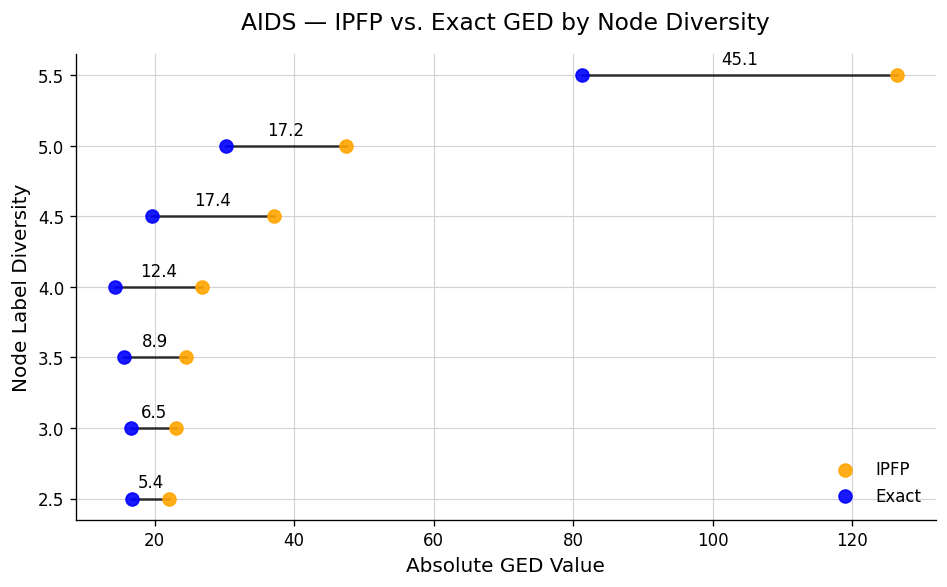

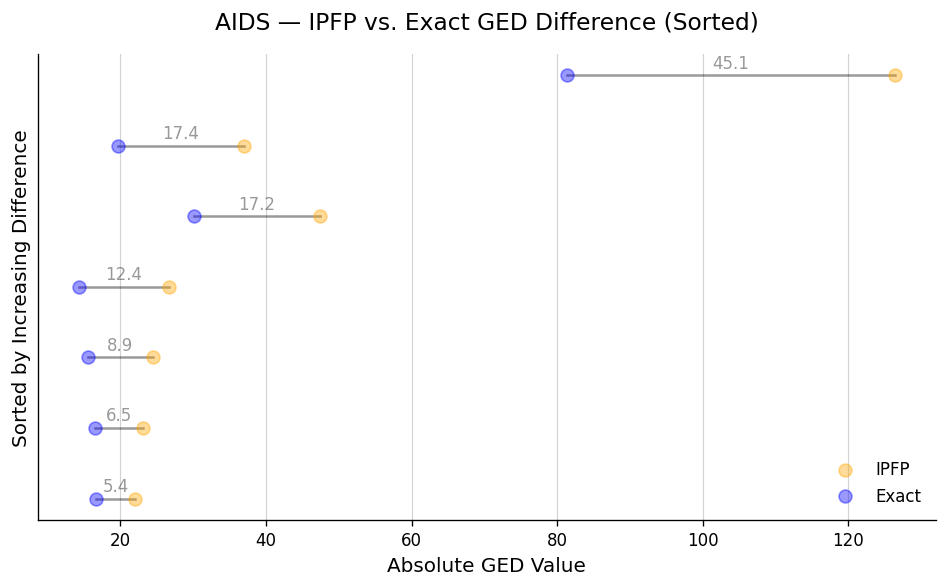

In [67]:
def plot_accuracy_vs_node_diversity_v2(dset, df_diversities):
    """
    Creates two visualizations comparing IPFP and Exact GED results:
    1. A slope chart comparing GED values across node diversity levels
    2. A sorted difference chart showing the same data sorted by difference magnitude
    """
    # --- Step 1: Collect IPFP data and filter ---
    ipfp_method = "IPFP"
    df_ipfp = get_df_with_diversities(dset, ipfp_method, df_diversities)
    df_ipfp_valid = df_ipfp.dropna(subset=["node_labels", "ged"])
    df_ipfp_valid = df_ipfp_valid[df_ipfp_valid["ged"] > 0]
    if df_ipfp_valid.empty:
        print(f"Skipping {ipfp_method} - No valid data available.")
        return

    # Group by node_labels and compute mean GED for IPFP
    df_ipfp_grouped = df_ipfp_valid.groupby("node_labels", as_index=False)["ged"].mean()

    # --- Step 2: Collect Exact data and filter ---
    df_exact = data[dset]["Exact"].copy()
    df_exact_merged = pd.merge(
        df_exact, df_diversities,
        on=["graph_id_1", "graph_id_2"],
        how="left",
        suffixes=("", "_div")
    )
    df_exact_valid = df_exact_merged.dropna(subset=["node_labels", "ged_exact"])
    df_exact_valid = df_exact_valid[df_exact_valid["ged_exact"] > 0]

    if df_exact_valid.empty:
        print("Skipping Exact - No valid data available.")
        df_exact_grouped = pd.DataFrame(columns=["node_labels", "ged_exact"])
    else:
        # Group by node_labels and compute mean GED for Exact
        df_exact_grouped = df_exact_valid.groupby("node_labels", as_index=False)["ged_exact"].mean()

    # --- Step 3: Keep only node_labels common to both IPFP and Exact ---
    common_labels = set(df_ipfp_grouped["node_labels"]).intersection(df_exact_grouped["node_labels"])
    df_ipfp_common = df_ipfp_grouped[df_ipfp_grouped["node_labels"].isin(common_labels)]
    df_exact_common = df_exact_grouped[df_exact_grouped["node_labels"].isin(common_labels)]
    merged_groups = pd.merge(df_ipfp_common, df_exact_common, on="node_labels", how="inner")

    # Sort by node_labels to get a nice top-to-bottom order
    merged_groups.sort_values("node_labels", ascending=True, inplace=True)

    # Create a new column for absolute difference between IPFP and Exact GED
    merged_groups['abs_difference'] = abs(merged_groups['ged'] - merged_groups['ged_exact'])

    # Sort by absolute difference for the second plot
    sorted_by_diff = merged_groups.sort_values('abs_difference', ascending=True)

    # --- Step 4: Create the main slope chart ---
    fig, ax = plt.subplots(figsize=(8, 5), dpi=120)

    # Remove top and right spines for a cleaner look
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # Plot IPFP points (orange)
    ax.scatter(
        merged_groups["ged"],
        merged_groups["node_labels"],
        s=60,            # smaller markers
        color="orange",
        label="IPFP",
        alpha=0.9,
        zorder=3
    )

    # Plot Exact points (blue)
    ax.scatter(
        merged_groups["ged_exact"],
        merged_groups["node_labels"],
        s=60,            # smaller markers
        color="blue",
        label="Exact",
        alpha=0.9,
        zorder=3
    )

    # Connect each pair with a black line and print the absolute error above it
    for _, row in merged_groups.iterrows():
        # Draw connecting line
        ax.plot(
            [row["ged"], row["ged_exact"]],
            [row["node_labels"], row["node_labels"]],
            color="black",
            lw=1.5,
            alpha=0.8,
            zorder=2
        )
        # Compute absolute error
        abs_err = abs(row["ged_exact"] - row["ged"])
        # Compute the x-position as the mid-point of the two values
        x_text = (row["ged"] + row["ged_exact"]) / 2
        # Set y-position slightly above the node label value
        y_text = row["node_labels"] + 0.05
        ax.text(x_text, y_text, f"{abs_err:.1f}", fontsize=10, ha="center", va="bottom", color="black")

    # Light gray grid for a clean look
    ax.grid(True, color="lightgrey", linestyle="-", linewidth=0.7)

    # Labels and Title
    ax.set_title(f"{dset} — IPFP vs. Exact GED by Node Diversity", fontsize=14, pad=15)
    ax.set_xlabel("Absolute GED Value", fontsize=12)
    ax.set_ylabel("Node Label Diversity", fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=10)

    # Move legend to lower right
    ax.legend(loc="lower right", frameon=False, fontsize=10)

    plt.tight_layout()
    plt.show()

    # --- Step 5: Create the second plot with sorted differences but no node labels ---
    fig2, ax2 = plt.subplots(figsize=(8, 5), dpi=120)

    # Remove top and right spines
    ax2.spines["top"].set_visible(False)
    ax2.spines["right"].set_visible(False)

    # Use index values instead of node labels for y-axis
    y_positions = np.arange(len(sorted_by_diff))

    # Plot IPFP points with reduced opacity
    ax2.scatter(
        sorted_by_diff["ged"],
        y_positions,
        s=60,
        color="orange",
        label="IPFP",
        alpha=0.4,
        zorder=3
    )

    # Plot Exact points with reduced opacity
    ax2.scatter(
        sorted_by_diff["ged_exact"],
        y_positions,
        s=60,
        color="blue",
        label="Exact",
        alpha=0.4,
        zorder=3
    )

    # Connect each pair with a black line
    for i, row in enumerate(sorted_by_diff.itertuples()):
        ax2.plot(
            [row.ged, row.ged_exact],
            [y_positions[i], y_positions[i]],
            color="black",
            lw=1.5,
            alpha=0.4,
            zorder=2
        )

        # Add absolute error text with reduced opacity
        x_text = (row.ged + row.ged_exact) / 2
        y_text = y_positions[i] + 0.05
        ax2.text(x_text, y_text, f"{row.abs_difference:.1f}",
                 fontsize=10, ha="center", va="bottom", color="black", alpha=0.4)

    # Light gray grid
    ax2.grid(True, color="lightgrey", linestyle="-", linewidth=0.7)

    # Labels and Title
    ax2.set_title(f"{dset} — IPFP vs. Exact GED Difference (Sorted)", fontsize=14, pad=15)
    ax2.set_xlabel("Absolute GED Value", fontsize=12)
    ax2.set_yticks([])  # Hide y-axis ticks
    ax2.set_ylabel("Sorted by Increasing Difference", fontsize=12)

    # Move legend to lower right
    ax2.legend(loc="lower right", frameon=False, fontsize=10)

    plt.tight_layout()
    plt.show()

plot_accuracy_vs_node_diversity_v2(dataset_name, df_diversities_merged)

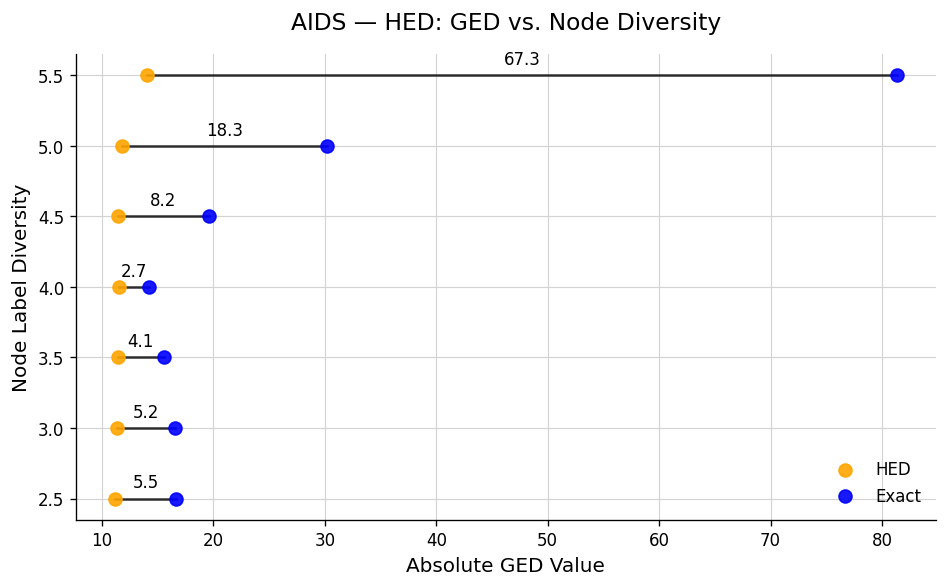

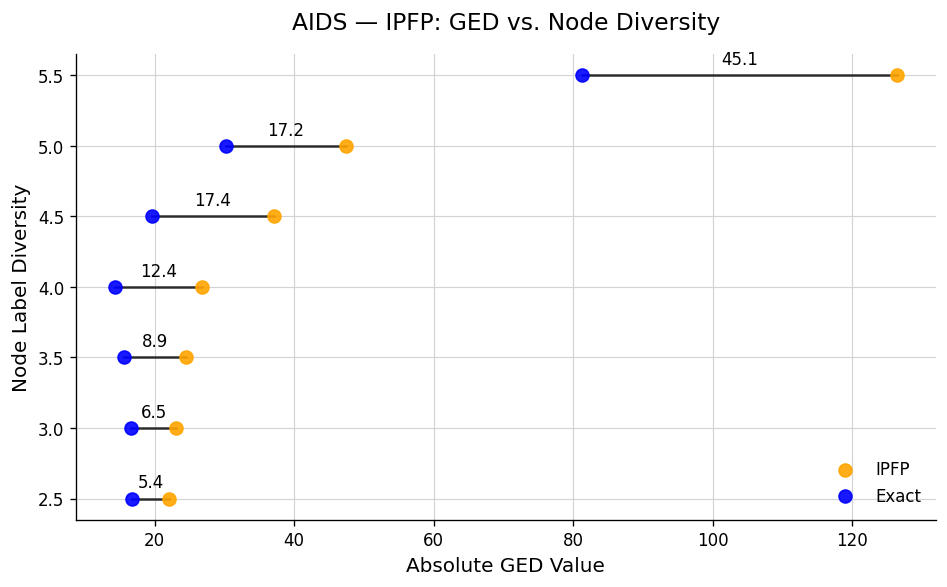

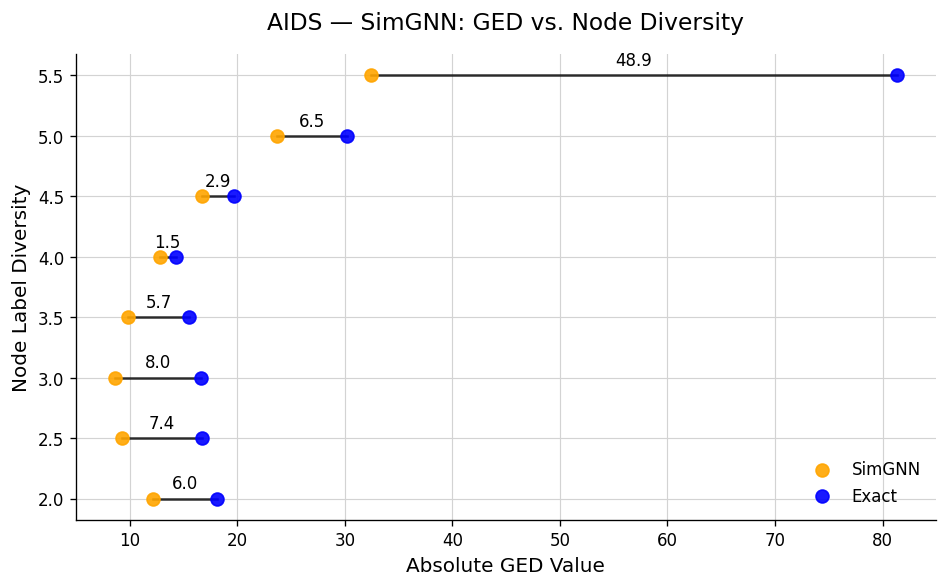

In [23]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def get_df_with_diversities(dset, method, df_diversities):
    df_method = data[dset][method].copy()
    df_merged = pd.merge(
        df_method, df_diversities,
        on=["graph_id_1", "graph_id_2"],
        how="left",
        suffixes=("", "_div")
    )
    # Only keep rows where accuracy is non-negative.
    df_merged = df_merged[df_merged["accuracy"] >= 0]
    return df_merged

def plot_accuracy_vs_node_diversity_all_algorithms(dset, df_diversities):
    """
    For the given dataset 'dset' and a DataFrame of diversities (df_diversities),
    create one slope-chart plot per algorithm (HED, IPFP, SimGNN). Each plot compares the
    mean GED value (grouped by node diversity) for the algorithm versus the Exact GED.
    A connecting line is drawn for each node diversity with the absolute error annotated above.
    """
    methods = ["HED", "IPFP", "SimGNN"]

    # Process Exact data once (common for all comparisons)
    df_exact = data[dset]["Exact"].copy()
    df_exact_merged = pd.merge(
        df_exact, df_diversities,
        on=["graph_id_1", "graph_id_2"],
        how="left",
        suffixes=("", "_div")
    )
    df_exact_valid = df_exact_merged.dropna(subset=["node_labels", "ged_exact"])
    df_exact_valid = df_exact_valid[df_exact_valid["ged_exact"] > 0]

    if df_exact_valid.empty:
        print("Skipping Exact - No valid data available.")
        return
    else:
        # Group by node_labels and compute mean Exact GED
        df_exact_grouped = df_exact_valid.groupby("node_labels", as_index=False)["ged_exact"].mean()

    # Loop through each algorithm to create a separate plot
    for method in methods:
        # --- Process algorithm data ---
        df_algo = get_df_with_diversities(dset, method, df_diversities)
        df_algo_valid = df_algo.dropna(subset=["node_labels", "ged"])
        df_algo_valid = df_algo_valid[df_algo_valid["ged"] > 0]
        if df_algo_valid.empty:
            print(f"Skipping {method} - No valid data available.")
            continue
        # Group by node_labels and compute mean GED for the current algorithm
        df_algo_grouped = df_algo_valid.groupby("node_labels", as_index=False)["ged"].mean()

        # --- Keep only node_labels common to both algorithm and Exact ---
        common_labels = set(df_algo_grouped["node_labels"]).intersection(df_exact_grouped["node_labels"])
        df_algo_common = df_algo_grouped[df_algo_grouped["node_labels"].isin(common_labels)]
        df_exact_common = df_exact_grouped[df_exact_grouped["node_labels"].isin(common_labels)]
        merged_groups = pd.merge(df_algo_common, df_exact_common, on="node_labels", how="inner")

        # Sort by node_labels for a clean top-to-bottom order
        merged_groups.sort_values("node_labels", ascending=True, inplace=True)

        # --- Create the slope chart for the current algorithm ---
        fig, ax = plt.subplots(figsize=(8, 5), dpi=120)

        # Remove top and right spines for a cleaner look
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

        # Plot algorithm points (using orange) and Exact points (using blue)
        ax.scatter(
            merged_groups["ged"],
            merged_groups["node_labels"],
            s=60, color="orange", label=method, alpha=0.9, zorder=3
        )
        ax.scatter(
            merged_groups["ged_exact"],
            merged_groups["node_labels"],
            s=60, color="blue", label="Exact", alpha=0.9, zorder=3
        )

        # Connect each pair with a line and annotate the absolute error
        for _, row in merged_groups.iterrows():
            ax.plot(
                [row["ged"], row["ged_exact"]],
                [row["node_labels"], row["node_labels"]],
                color="black", lw=1.5, alpha=0.8, zorder=2
            )
            abs_err = abs(row["ged_exact"] - row["ged"])
            x_text = (row["ged"] + row["ged_exact"]) / 2
            y_text = row["node_labels"] + 0.05  # Slight offset above the point
            ax.text(x_text, y_text, f"{abs_err:.1f}", fontsize=10,
                    ha="center", va="bottom", color="black")

        # Set grid, labels, title, and legend
        ax.grid(True, color="lightgrey", linestyle="-", linewidth=0.7)
        ax.set_xlabel("Absolute GED Value", fontsize=12)
        ax.set_ylabel("Node Label Diversity", fontsize=12)
        ax.set_title(f"{dset} — {method}: GED vs. Node Diversity", fontsize=14, pad=15)
        ax.tick_params(axis="both", which="major", labelsize=10)
        ax.legend(loc="lower right", frameon=False, fontsize=10)

        plt.tight_layout()
        plt.show()

# Example usage:
plot_accuracy_vs_node_diversity_all_algorithms("AIDS", df_diversities_merged)


In [25]:


def plot_accuracy_vs_size(dset, df_diversities):
    # --- Step 1: Collect IPFP data and filter ---
    ipfp_method = "IPFP"
    df_ipfp = get_df_with_diversities(dset, ipfp_method, df_diversities)
    df_ipfp_valid = df_ipfp.dropna(subset=["node_labels", "ged"])
    df_ipfp_valid = df_ipfp_valid[df_ipfp_valid["ged"] > 0]
    if df_ipfp_valid.empty:
        print(f"Skipping {ipfp_method} - No valid data available.")
        return

    # Group by node_labels and compute mean GED for IPFP
    df_ipfp_grouped = df_ipfp_valid.groupby("node_labels", as_index=False)["ged"].mean()

    # --- Step 2: Collect Exact data and filter ---
    df_exact = data[dset]["Exact"].copy()
    df_exact_merged = pd.merge(
        df_exact, df_diversities,
        on=["graph_id_1", "graph_id_2"],
        how="left",
        suffixes=("", "_div")
    )
    df_exact_valid = df_exact_merged.dropna(subset=["node_labels", "ged_exact"])
    df_exact_valid = df_exact_valid[df_exact_valid["ged_exact"] > 0]

    if df_exact_valid.empty:
        print("Skipping Exact - No valid data available.")
        df_exact_grouped = pd.DataFrame(columns=["node_labels", "ged_exact"])
    else:
        # Group by node_labels and compute mean GED for Exact
        df_exact_grouped = df_exact_valid.groupby("node_labels", as_index=False)["ged_exact"].mean()

    # --- Step 3: Keep only node_labels common to both IPFP and Exact ---
    common_labels = set(df_ipfp_grouped["node_labels"]).intersection(df_exact_grouped["node_labels"])
    df_ipfp_common = df_ipfp_grouped[df_ipfp_grouped["node_labels"].isin(common_labels)]
    df_exact_common = df_exact_grouped[df_exact_grouped["node_labels"].isin(common_labels)]
    merged_groups = pd.merge(df_ipfp_common, df_exact_common, on="node_labels", how="inner")

    # Sort by node_labels to get a nice top-to-bottom order
    merged_groups.sort_values("node_labels", ascending=True, inplace=True)

    # --- Step 4: Create the slope chart ---
    fig, ax = plt.subplots(figsize=(8, 5), dpi=120)

    # Remove top and right spines for a cleaner look
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # Plot IPFP points (orange)
    ax.scatter(
        merged_groups["ged"],
        merged_groups["node_labels"],
        s=60,            # smaller markers
        color="orange",
        label="IPFP",
        alpha=0.9,
        zorder=3
    )

    # Plot Exact points (blue)
    ax.scatter(
        merged_groups["ged_exact"],
        merged_groups["node_labels"],
        s=60,            # smaller markers
        color="blue",
        label="Exact",
        alpha=0.9,
        zorder=3
    )

    # Connect each pair with a black line and print the absolute error above it
    for _, row in merged_groups.iterrows():
        # Draw connecting line
        ax.plot(
            [row["ged"], row["ged_exact"]],
            [row["node_labels"], row["node_labels"]],
            color="black",
            lw=1.5,
            alpha=0.8,
            zorder=2
        )
        # Compute absolute error
        abs_err = abs(row["ged_exact"] - row["ged"])
        # Compute the x-position as the mid-point of the two values
        x_text = (row["ged"] + row["ged_exact"]) / 2
        # Set y-position slightly above the node label value
        y_text = row["node_labels"] + 0.05
        ax.text(x_text, y_text, f"{abs_err:.1f}", fontsize=10, ha="center", va="bottom", color="black")

    # Light gray grid for a clean look
    ax.grid(True, color="lightgrey", linestyle="-", linewidth=0.7)

    # Labels and Title
    ax.set_title(f"{dset} — IPFP vs. Exact GED by Node Diversity", fontsize=14, pad=15)
    ax.set_xlabel("GED Value", fontsize=12)
    ax.set_ylabel("Node Label Diversity", fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=10)

    # Move legend to lower right
    ax.legend(loc="lower right", frameon=False, fontsize=10)

    plt.tight_layout()
    plt.show()


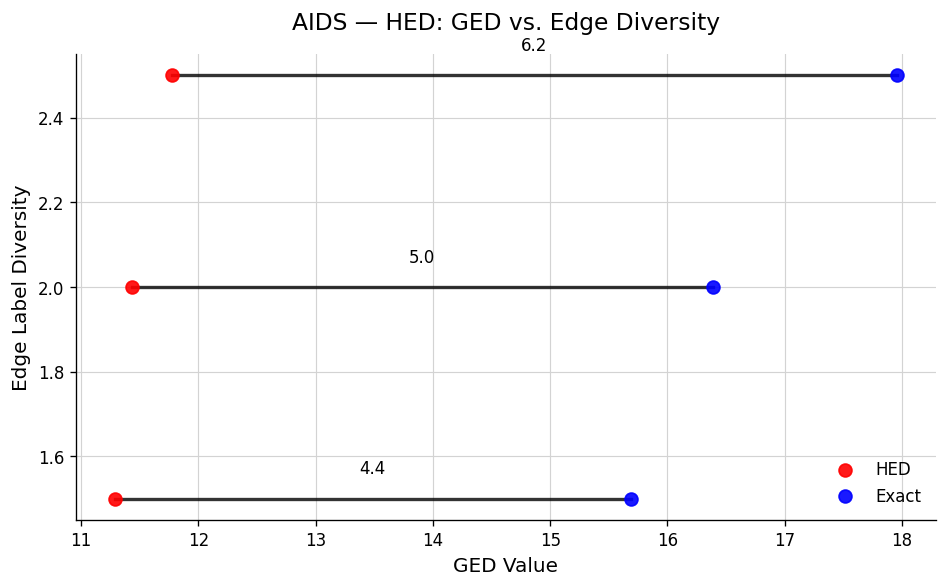

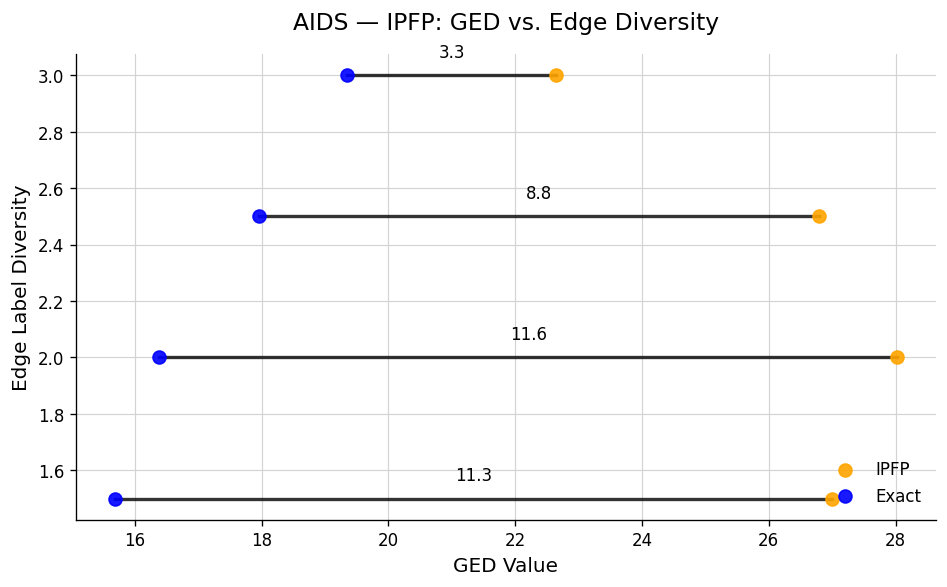

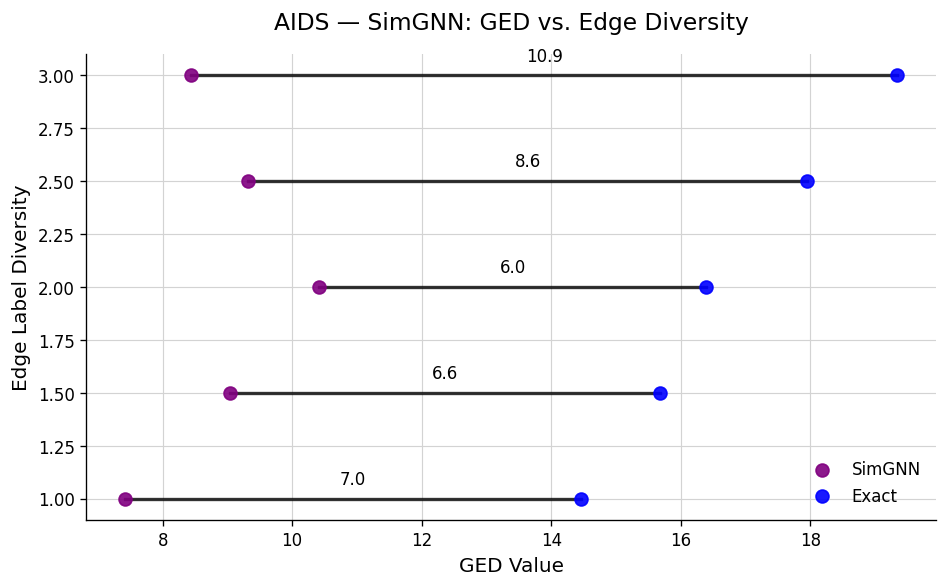

In [28]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def get_df_with_diversities(dset, method, df_diversities):
    df_method = data[dset][method].copy()
    df_merged = pd.merge(
        df_method, df_diversities,
        on=["graph_id_1", "graph_id_2"],
        how="left",
        suffixes=("", "_div")
    )
    # Only keep rows where accuracy is non-negative.
    df_merged = df_merged[df_merged["accuracy"] >= 0]
    return df_merged

def plot_accuracy_vs_edge_diversity_all_algorithms(dset, df_diversities):
    """
    For the given dataset 'dset' and a DataFrame of diversities (df_diversities),
    create one slope-chart plot per algorithm (HED, IPFP, SimGNN) comparing the
    mean GED values (grouped by edge diversity) of the algorithm versus Exact.
    A bold connecting line is drawn for each common edge diversity, with the absolute
    difference (|Exact - Algorithm|) annotated above the line.
    """
    methods = ["HED", "IPFP", "SimGNN"]
    # Define colors for each algorithm; Exact is always blue.
    method_colors = {"HED": "red", "IPFP": "orange", "SimGNN": "purple"}
    exact_color = "blue"

    # Process Exact data once (common for all comparisons)
    df_exact = data[dset]["Exact"].copy()
    df_exact_merged = pd.merge(
        df_exact, df_diversities,
        on=["graph_id_1", "graph_id_2"],
        how="left",
        suffixes=("", "_div")
    )
    df_exact_valid = df_exact_merged.dropna(subset=["edge_labels", "ged_exact"])
    df_exact_valid = df_exact_valid[df_exact_valid["ged_exact"] > 0]
    if df_exact_valid.empty:
        print("Skipping Exact - No valid data available.")
        return
    else:
        # Group by edge_labels and compute mean Exact GED.
        df_exact_grouped = df_exact_valid.groupby("edge_labels", as_index=False)["ged_exact"].mean()

    # Loop through each algorithm to create a separate plot.
    for method in methods:
        # --- Process algorithm data ---
        df_algo = get_df_with_diversities(dset, method, df_diversities)
        df_algo_valid = df_algo.dropna(subset=["edge_labels", "ged"])
        df_algo_valid = df_algo_valid[df_algo_valid["ged"] > 0]
        if df_algo_valid.empty:
            print(f"Skipping {method} - No valid data available.")
            continue
        # Group by edge_labels and compute mean GED for the algorithm.
        df_algo_grouped = df_algo_valid.groupby("edge_labels", as_index=False)["ged"].mean()

        # --- Keep Only Common Edge Diversity Values ---
        common_labels = set(df_algo_grouped["edge_labels"]).intersection(df_exact_grouped["edge_labels"])
        df_algo_common = df_algo_grouped[df_algo_grouped["edge_labels"].isin(common_labels)]
        df_exact_common = df_exact_grouped[df_exact_grouped["edge_labels"].isin(common_labels)]
        merged_groups = pd.merge(df_algo_common, df_exact_common, on="edge_labels", how="inner")
        merged_groups.sort_values("edge_labels", ascending=True, inplace=True)

        # --- Create the slope chart for the current algorithm ---
        fig, ax = plt.subplots(figsize=(8, 5), dpi=120)

        # Remove top and right spines for a cleaner look.
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

        # Plot algorithm points (using its designated color).
        ax.scatter(
            merged_groups["ged"],
            merged_groups["edge_labels"],
            s=60, color=method_colors.get(method, None),
            label=method, alpha=0.9, zorder=3
        )

        # Plot Exact points (blue).
        ax.scatter(
            merged_groups["ged_exact"],
            merged_groups["edge_labels"],
            s=60, color=exact_color,
            label="Exact", alpha=0.9, zorder=3
        )

        # Connect each pair with a bold black line and annotate the absolute error.
        for _, row in merged_groups.iterrows():
            ax.plot(
                [row["ged"], row["ged_exact"]],
                [row["edge_labels"], row["edge_labels"]],
                color="black", lw=2, alpha=0.8, zorder=2
            )
            abs_err = abs(row["ged_exact"] - row["ged"])
            x_text = (row["ged"] + row["ged_exact"]) / 2
            y_text = row["edge_labels"] + 0.05  # Adjust offset as needed
            ax.text(x_text, y_text, f"{abs_err:.1f}", fontsize=10,
                    ha="center", va="bottom", color="black")

        # Grid, labels, title, and legend.
        ax.grid(True, color="lightgrey", linestyle="-", linewidth=0.7)
        ax.set_title(f"{dset} — {method}: GED vs. Edge Diversity", fontsize=14, pad=15)
        ax.set_xlabel("GED Value", fontsize=12)
        ax.set_ylabel("Edge Label Diversity", fontsize=12)
        ax.tick_params(axis="both", which="major", labelsize=10)
        ax.legend(loc="lower right", frameon=False, fontsize=10)

        plt.tight_layout()
        plt.show()

# Example usage:
plot_accuracy_vs_edge_diversity_all_algorithms(dataset_name, df_diversities_merged)


## 7. Scatter plot for Accuracy Analysis

In [29]:
import matplotlib as mpl

def plot_accuracy_scatter(dset, method):
    """
    For the chosen dataset `dset` and given `method`, create a 2D hexbin plot
    comparing the approximate GED results (ged) against the exact GED results (ged_exact).

    Each hexagon is colored by the count of observations in that bin,
    using a custom lavender colormap from very light (#E6E6FA) to bright (#8A2BE2).
    The diagonal (y = x) represents the exact GED.
    The figure is sized to an HD-like resolution (1280x720).
    """

    # Define a custom lavender colormap from light to bright
    lavender_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        "LavenderMap",
        ["#E6E6FA", "#B299FF", "#8A2BE2"]  # Light → Medium → Bright lavender
    )

    # Set HD-like resolution: 12.8" x 7.2" at 100 DPI ~ 1280 x 720 pixels
    plt.figure(figsize=(12.8, 7.2), dpi=100)

    # Collect all (x, y) points for the chosen method
    all_exact = []
    all_approx = []
    df_method = data[dset][method].dropna(subset=['ged', 'ged_exact'])
    all_exact.extend(df_method["ged_exact"].tolist())
    all_approx.extend(df_method["ged"].tolist())

    # Plot hexbin only if we have points
    if all_exact and all_approx:
        hb = plt.hexbin(
            all_exact,
            all_approx,
            gridsize=100,          # number of hexagons along each axis
            cmap=lavender_cmap,   # our custom lavender colormap
            mincnt=1              # only color bins that have at least one point
        )
        cb = plt.colorbar(hb)
        cb.set_label("Count")

        # Draw the diagonal
        lower = min(min(all_exact), min(all_approx))
        upper = max(max(all_exact), max(all_approx))
        plt.plot([lower, upper], [lower, upper], 'k--', label="Exact GED (y = x)")

    # Clamp axes to [0, 250]
    limit = 40
    plt.xlim(0, limit)
    plt.ylim(0, limit)

    plt.title(f"{dset} — Approximate GED vs Exact GED (Hexbin: {method})")
    plt.xlabel("Exact GED")
    plt.ylabel("Approximate GED")
    plt.grid(True)
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()

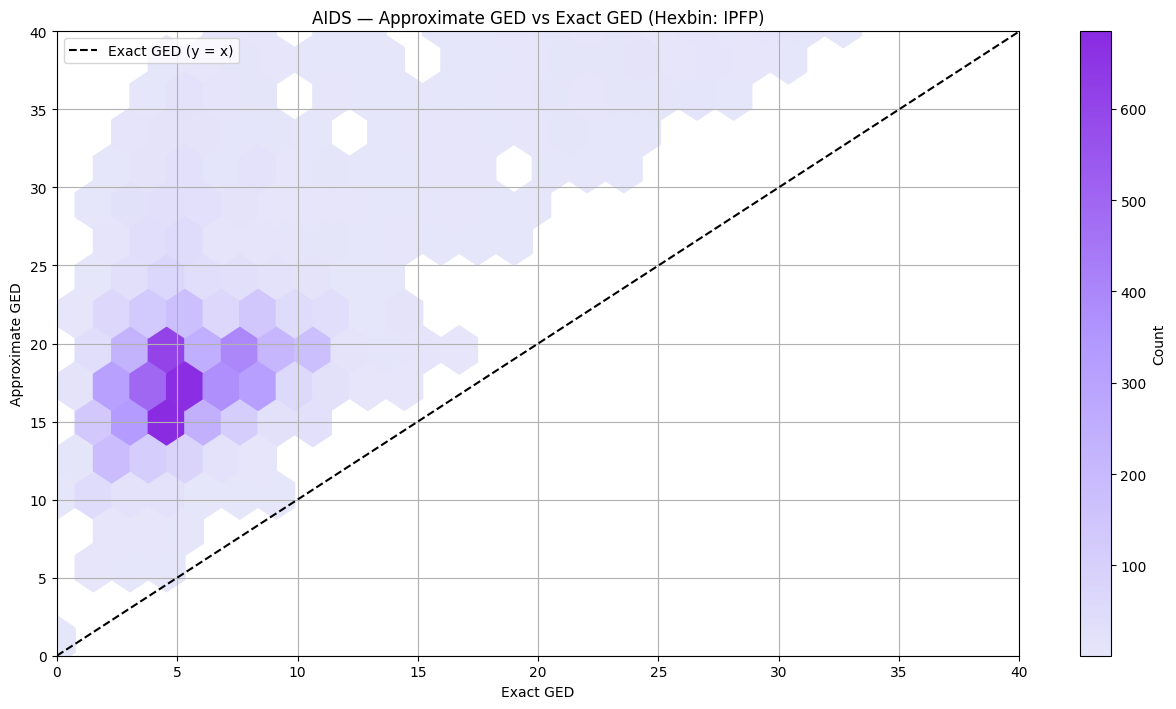

In [30]:
plot_accuracy_scatter("AIDS", "IPFP")

In [31]:
!{sys.executable} -m pip install statsmodels
from statsmodels.nonparametric.smoothers_lowess import lowess


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [32]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.nonparametric.smoothers_lowess import lowess

def plot_runtime_by_size(dset):
    """
    Plots the runtime (in ms) vs. graph size for each method (HED, IPFP, SimGNN),
    with a black line (or scatter) showing the grouped average runtime, and a LOESS smooth
    curve (colored lavender).
    """
    methods = ["HED", "IPFP", "SimGNN"]

    fig, axes = plt.subplots(nrows=len(methods), figsize=(12.8, 7.2), sharex=True, dpi=120)

    # If there's only one method, axes is not a list
    if len(methods) == 1:
        axes = [axes]

    for i, method in enumerate(methods):
        df_method = data[dset][method]
        # Drop rows with missing runtime
        df_method = df_method.dropna(subset=["runtime"])
        # Remove rows where runtime is zero or near zero (threshold can be adjusted)
        df_method = df_method[(df_method["runtime"] > 0) & (df_method["runtime"] < 6)]

        # Merge to get graph_size from SimGNN if needed
        df_simgnn = data[dset]["SimGNN"][["graph_id_1", "graph_id_2", "graph_size"]]
        df_method = pd.merge(
            df_method,
            df_simgnn,
            on=["graph_id_1", "graph_id_2"],
            how="left",
            suffixes=("", "_simgnn")
        )
        df_method["graph_size"] = df_method["graph_size_simgnn"]
        df_method = df_method.dropna(subset=["graph_size", "runtime"])

        if df_method.empty:
            axes[i].text(0.5, 0.5, f"No data for {method}",
                         ha='center', va='center', transform=axes[i].transAxes)
            continue

        # Convert runtime to milliseconds
        df_method["runtime_ms"] = df_method["runtime"] * 1000

        # Convert graph_size to integer for grouping
        df_method["graph_size_int"] = df_method["graph_size"].astype(int)

        # Group by integer graph size
        grouped = (
            df_method.groupby("graph_size_int")["runtime_ms"]
            .mean()
            .reset_index()
            .sort_values("graph_size_int")
        )

        # Plot average runtime as a black line (or scatter if only 1 point)
        if grouped["graph_size_int"].nunique() > 1:
            axes[i].plot(
                grouped["graph_size_int"],
                grouped["runtime_ms"],
                color="black",
                label="Avg. Runtime"
            )
        else:
            axes[i].scatter(
                grouped["graph_size_int"],
                grouped["runtime_ms"],
                color="black",
                label="Avg. Runtime"
            )

        # --- Add LOESS smooth curve in lavender ---
        # Only do LOESS if we have multiple x-values
        if grouped["graph_size_int"].nunique() > 1:
            x_vals = grouped["graph_size_int"].values
            y_vals = grouped["runtime_ms"].values

            # frac=0.3 controls the smoothness; adjust as needed
            loess_smoothed = lowess(endog=y_vals, exog=x_vals, frac=0.3)
            # loess_smoothed is Nx2 array: first column x, second column smoothed y
            axes[i].plot(
                loess_smoothed[:, 0],
                loess_smoothed[:, 1],
                color="red",
                linewidth=2,
                label="LOESS Smooth"
            )

        axes[i].set_title(f"{method}")
        axes[i].set_ylabel("Runtime (ms)")
        axes[i].grid(True)

        # Set x-limits based on min and max integer graph size
        min_size = grouped["graph_size_int"].min()
        max_size = grouped["graph_size_int"].max()
        axes[i].set_xlim(min_size - 1, max_size + 1)

        # Optionally add a legend
        axes[i].legend(loc="best")

    # Shared X-axis label
    axes[-1].set_xlabel("Graph Size")
    fig.suptitle(f"{dset} — Runtime by Graph Size")
    plt.tight_layout()
    plt.show()

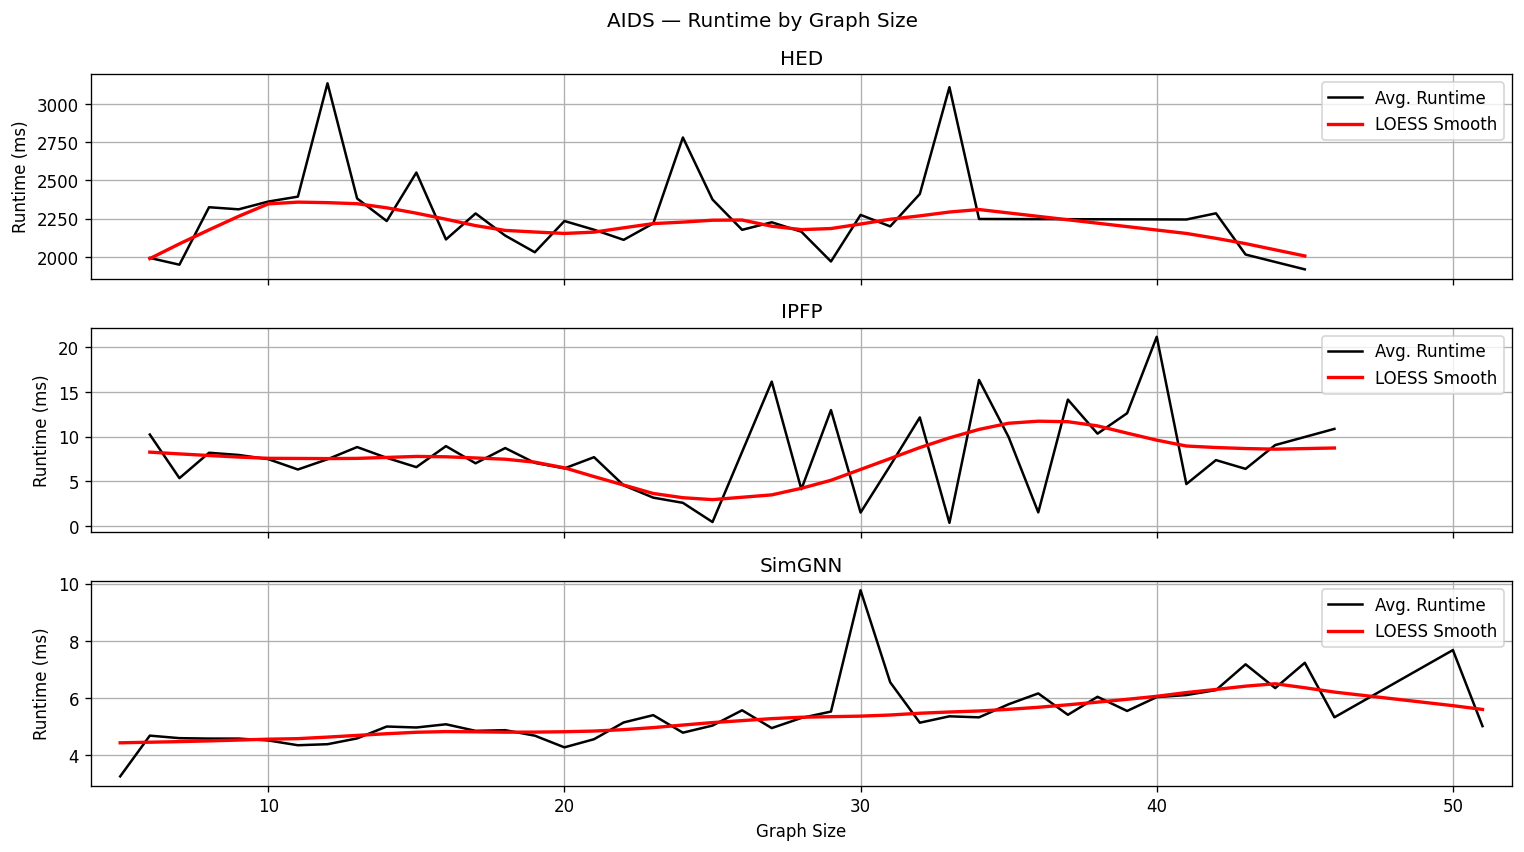

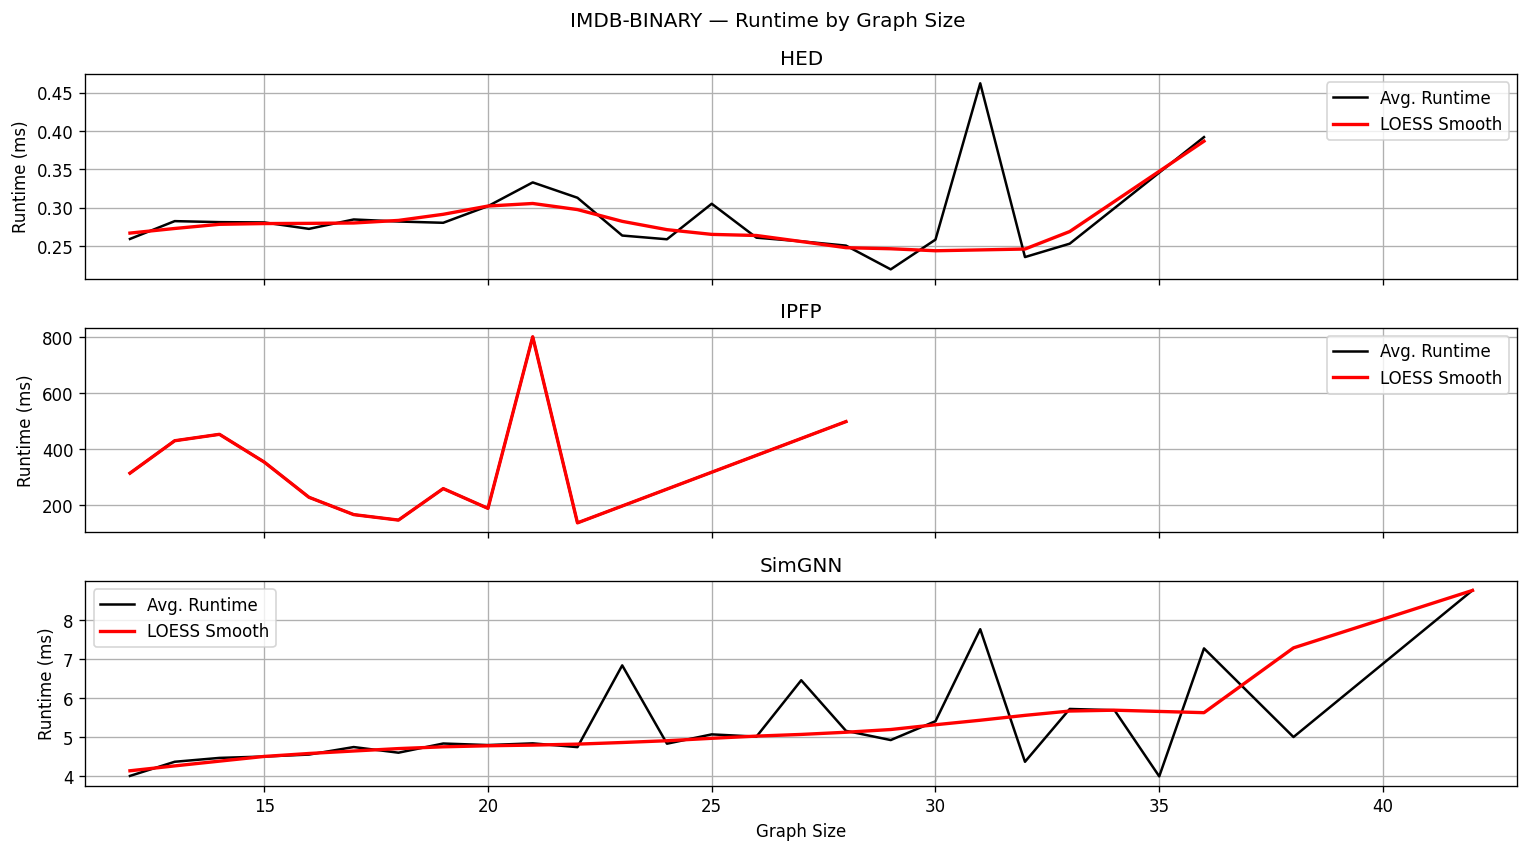

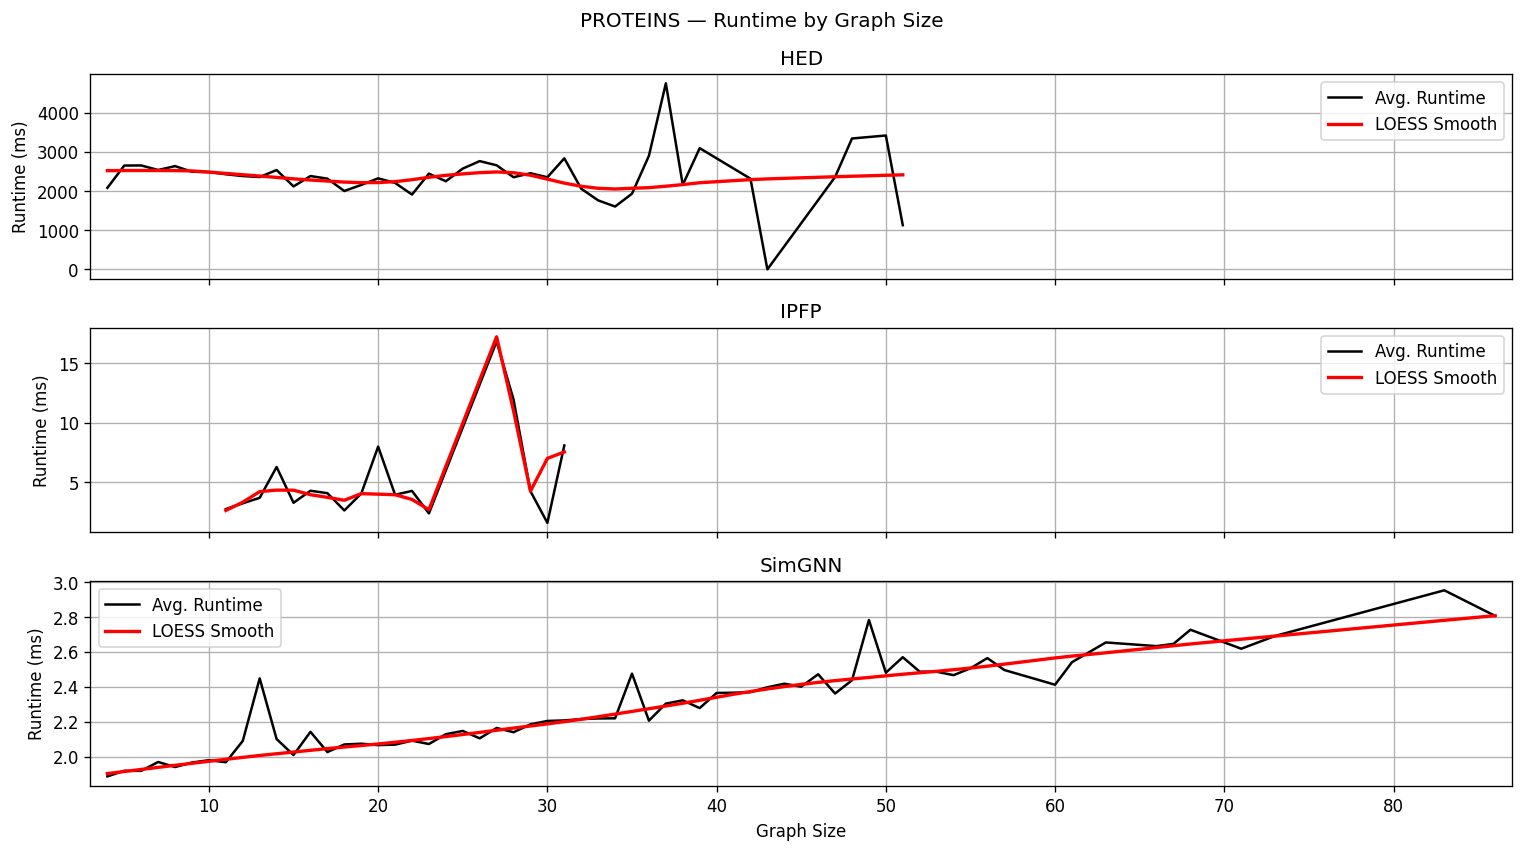

In [33]:
plot_runtime_by_size("AIDS")
plot_runtime_by_size("IMDB-BINARY")
plot_runtime_by_size("PROTEINS")


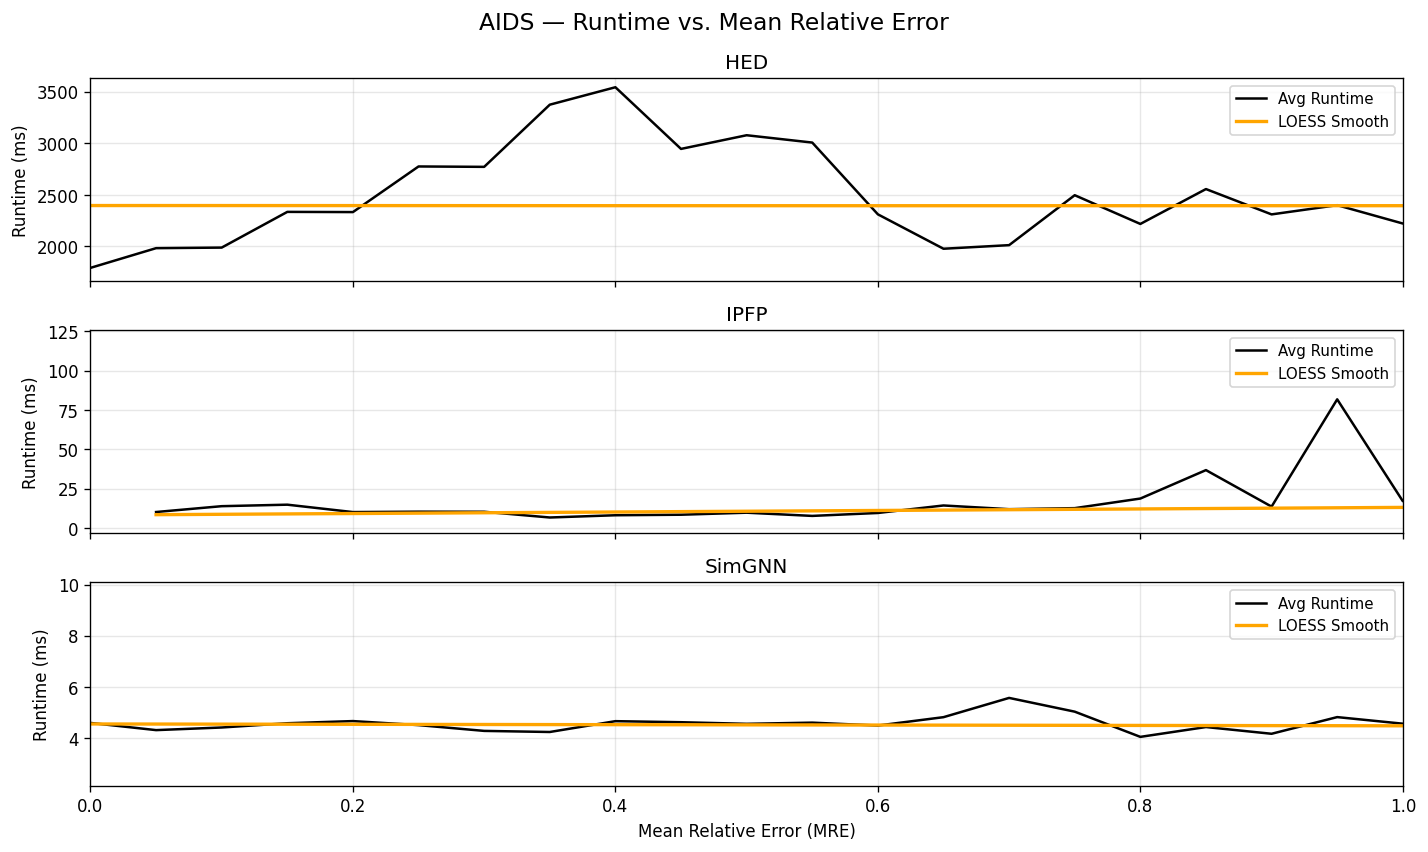

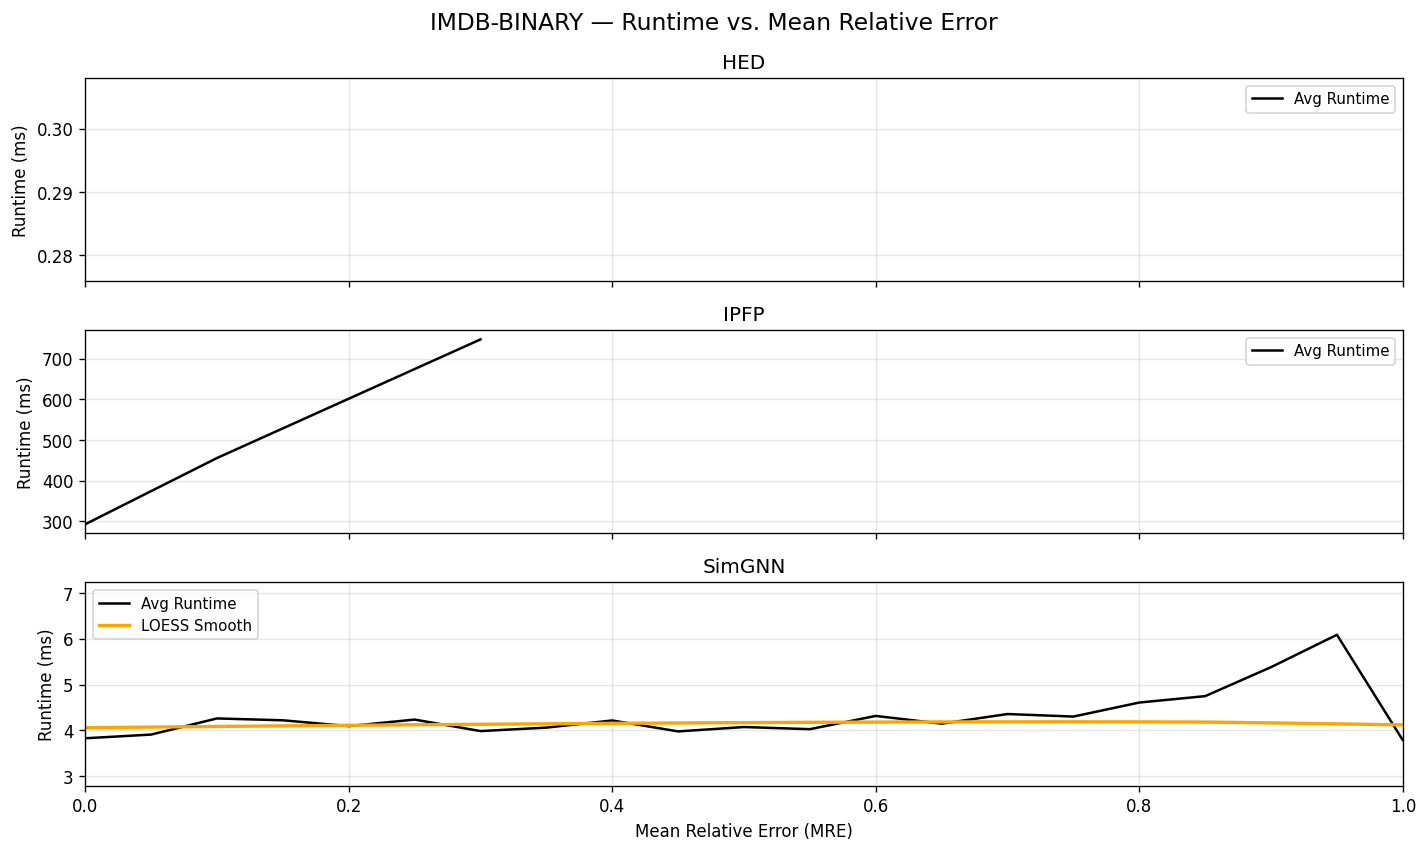

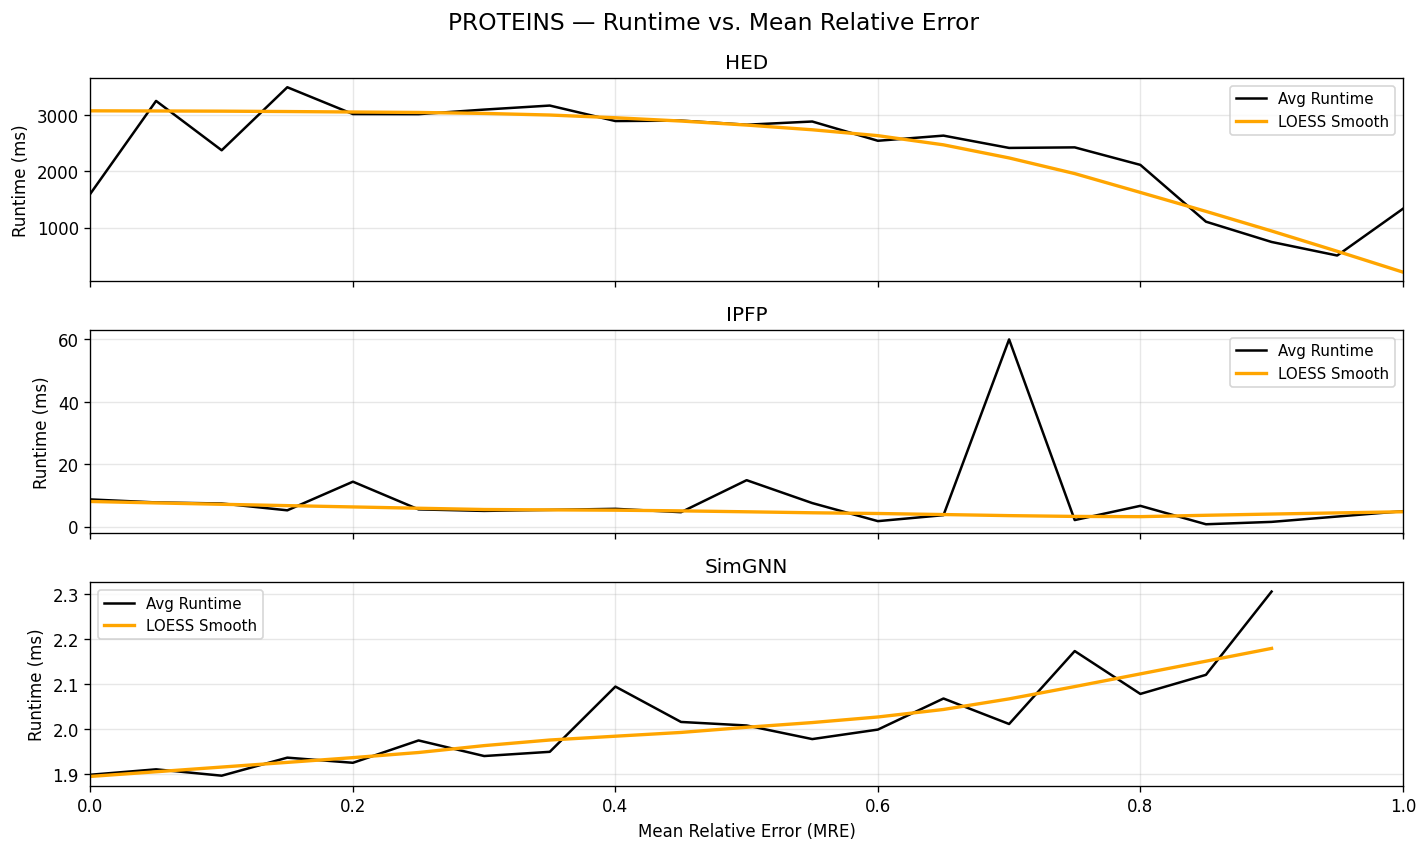

In [44]:
def plot_runtime_vs_mre(dset):
        """
        Plots the runtime (in ms) vs. mean relative error (MRE) for each method (HED, IPFP, SimGNN).
        """
        methods = ["HED", "IPFP", "SimGNN"]

        fig, axes = plt.subplots(nrows=len(methods), figsize=(12, 7.2), sharex=True, dpi=120)

        # If there's only one method, axes is not a list
        if len(methods) == 1:
            axes = [axes]

        for i, method in enumerate(methods):
            df_method = data[dset][method]

            # Drop rows with missing runtime or prediction
            df_method = df_method.dropna(subset=["runtime", "ged", "ged_exact"])

            # Remove extreme runtimes
            df_method = df_method[(df_method["runtime"] > 0) & (df_method["runtime"] < 6)]

            if df_method.empty:
                axes[i].text(0.5, 0.5, f"No data for {method}",
                           ha='center', va='center', transform=axes[i].transAxes)
                continue

            # Calculate relative error for each graph pair
            df_method['relative_error'] = abs(df_method['ged'] - df_method['ged_exact']) / df_method['ged_exact']

            # Convert runtime to milliseconds
            df_method['runtime_ms'] = df_method['runtime'] * 1000

            # Round MRE to create reasonable groups (e.g., 0.05 increments)
            df_method['mre_rounded'] = (df_method['relative_error'] * 20).round() / 20

            # Group by rounded MRE and calculate mean runtime
            grouped = df_method.groupby('mre_rounded')['runtime_ms'].mean().reset_index()
            grouped = grouped.sort_values('mre_rounded')

            # Plot only the line without markers
            axes[i].plot(
                grouped['mre_rounded'],
                grouped['runtime_ms'],
                '-',  # Changed from 'o-' to '-' to remove the dots
                color='black',
                linewidth=1.5,
                label='Avg Runtime'
            )

            # Add LOESS smooth curve if enough data points
            if len(grouped) > 3:
                try:
                    x = grouped['mre_rounded'].values
                    y = grouped['runtime_ms'].values

                    loess_smoothed = lowess(y, x, frac=0.6)

                    axes[i].plot(
                        loess_smoothed[:, 0],
                        loess_smoothed[:, 1],
                        color='orange',
                        linewidth=2,
                        label='LOESS Smooth'
                    )
                except Exception as e:
                    print(f"LOESS error for {method}: {e}")

            # Format plot
            axes[i].set_title(f"{method}", fontsize=12)
            axes[i].set_ylabel("Runtime (ms)", fontsize=10)
            axes[i].grid(True, alpha=0.3)
            axes[i].set_xlim(0, min(2.0, grouped['mre_rounded'].max() * 1.1))
            axes[i].legend(loc="best", fontsize=9)

        # Shared x-axis label
        axes[-1].set_xlabel("Mean Relative Error (MRE)", fontsize=10)
        axes[-1].set_xlim(0,1)
        fig.suptitle(f"{dset} — Runtime vs. Mean Relative Error", fontsize=14)
        plt.tight_layout()
        plt.show()

plot_runtime_vs_mre("AIDS")
plot_runtime_vs_mre("IMDB-BINARY")
plot_runtime_vs_mre("PROTEINS")

In [47]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.nonparametric.smoothers_lowess import lowess

def plot_runtime_by_density(dset):
    """
    Plots the runtime (in ms) vs. graph density (0–1) for each method (HED, IPFP, SimGNN).
    A black line shows the binned average runtime, and a LOESS smooth curve in lavender
    is superimposed to show the smoothed trend.

    The figure is sized to HD-like resolution (1280x720).
    """
    methods = ["HED", "IPFP", "SimGNN"]

    fig, axes = plt.subplots(nrows=len(methods), figsize=(12.8, 7.2), sharex=True, dpi=100)

    # If there's only one method in the list, axes won't be a list
    if len(methods) == 1:
        axes = [axes]

    for i, method in enumerate(methods):
        df_method = data[dset][method]

        # Drop rows with missing runtime
        df_method = df_method.dropna(subset=["runtime"])

        # Merge to get graph_density from SimGNN if needed
        df_simgnn = data[dset]["SimGNN"][["graph_id_1", "graph_id_2", "graph_density"]]
        df_method = pd.merge(
            df_method,
            df_simgnn,
            on=["graph_id_1", "graph_id_2"],
            how="left",
            suffixes=("", "_simgnn")
        )

        df_method["graph_density"] = df_method["graph_density_simgnn"]
        df_method = df_method.dropna(subset=["graph_density", "runtime"])
        if df_method.empty:
            axes[i].text(0.5, 0.5, f"No data for {method}", ha='center', va='center',
                         transform=axes[i].transAxes)
            continue

        # Convert runtime to milliseconds
        df_method["runtime_ms"] = df_method["runtime"] * 1000

        # Filter out runtime outliers using the IQR method
        q1 = df_method["runtime_ms"].quantile(0.25)
        q3 = df_method["runtime_ms"].quantile(0.75)
        iqr = q3 - q1
        upper_bound = q3 + 1.5 * iqr
        df_method = df_method[df_method["runtime_ms"] <= upper_bound]

        # Bin density in [0..100]
        df_method["density_bin"] = (df_method["graph_density"] * 100).astype(int)
        df_plot = df_method[
            (df_method["density_bin"] >= 0) &
            (df_method["density_bin"] <= 100)
        ]

        # Group by binned density and compute average runtime
        grouped = df_plot.groupby("density_bin")["runtime_ms"].mean().reset_index()
        grouped["density_float"] = grouped["density_bin"] / 100.0

        # Plot the average runtime as black line (or scatter if only one bin)
        if grouped["density_bin"].nunique() > 1:
            axes[i].plot(grouped["density_float"], grouped["runtime_ms"], color="black",
                         label="Average Runtime")
        else:
            axes[i].scatter(grouped["density_float"], grouped["runtime_ms"], color="black",
                            label="Average Runtime")

        # --- Add LOESS smooth curve in lavender ---
        if grouped["density_bin"].nunique() > 1:
            x_vals = grouped["density_float"].values
            y_vals = grouped["runtime_ms"].values

            # frac=0.3 controls smoothing; adjust if desired
            loess_smoothed = lowess(endog=y_vals, exog=x_vals, frac=0.3)
            # loess_smoothed is an Nx2 array: first col = x, second col = smoothed y
            axes[i].plot(
                loess_smoothed[:, 0],
                loess_smoothed[:, 1],
                color="orange",
                linewidth=2,
                label="LOESS Smooth"
            )
            axes[i].legend(loc="best")

        axes[i].set_title(f"{method}")
        axes[i].set_ylabel("Runtime (ms)")
        axes[i].grid(True)

    axes[-1].set_xlabel("Graph Density (0–1)")
    axes[-1].set_xlim(0, 0.6)

    fig.suptitle(f"{dset} — Runtime by Density")
    plt.tight_layout()
    plt.show()

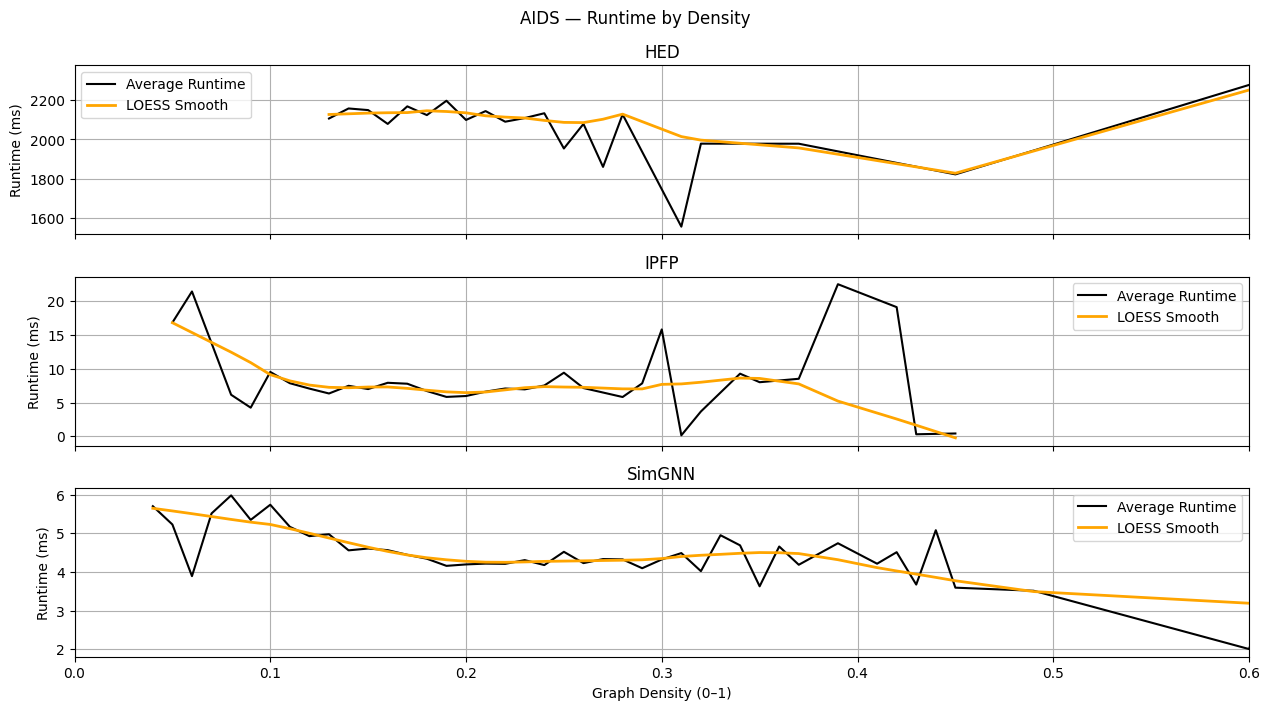

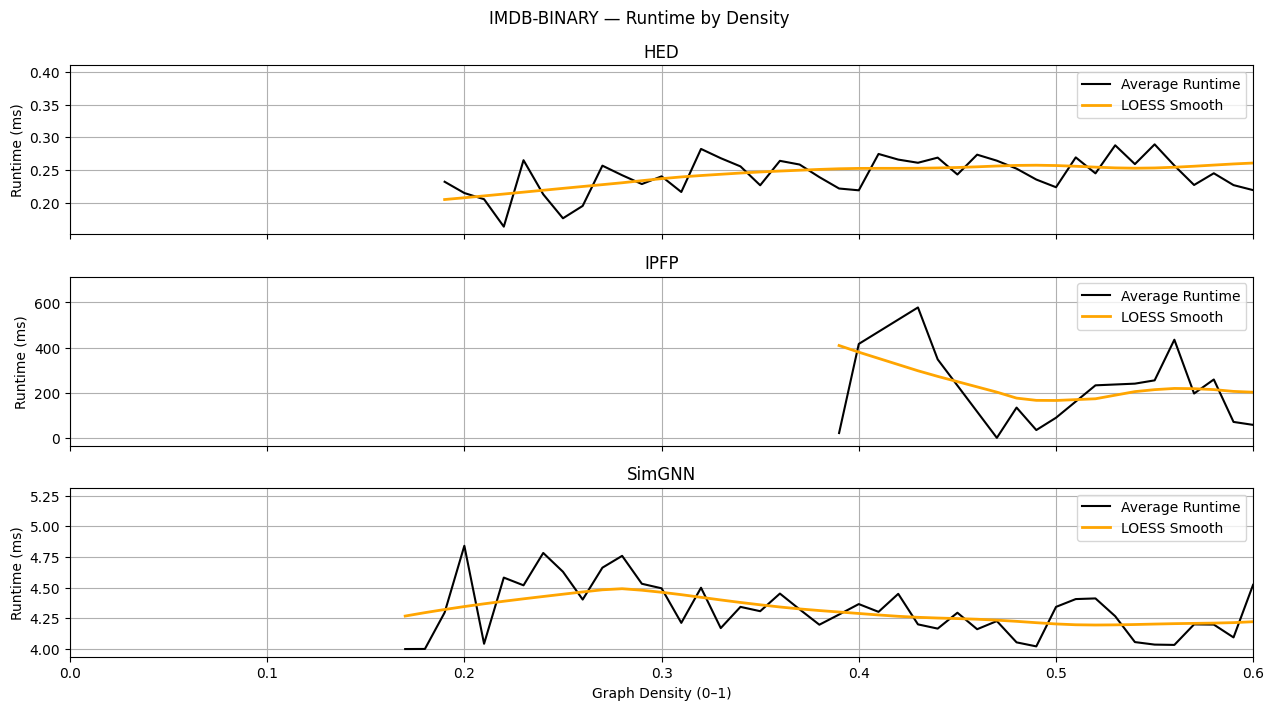

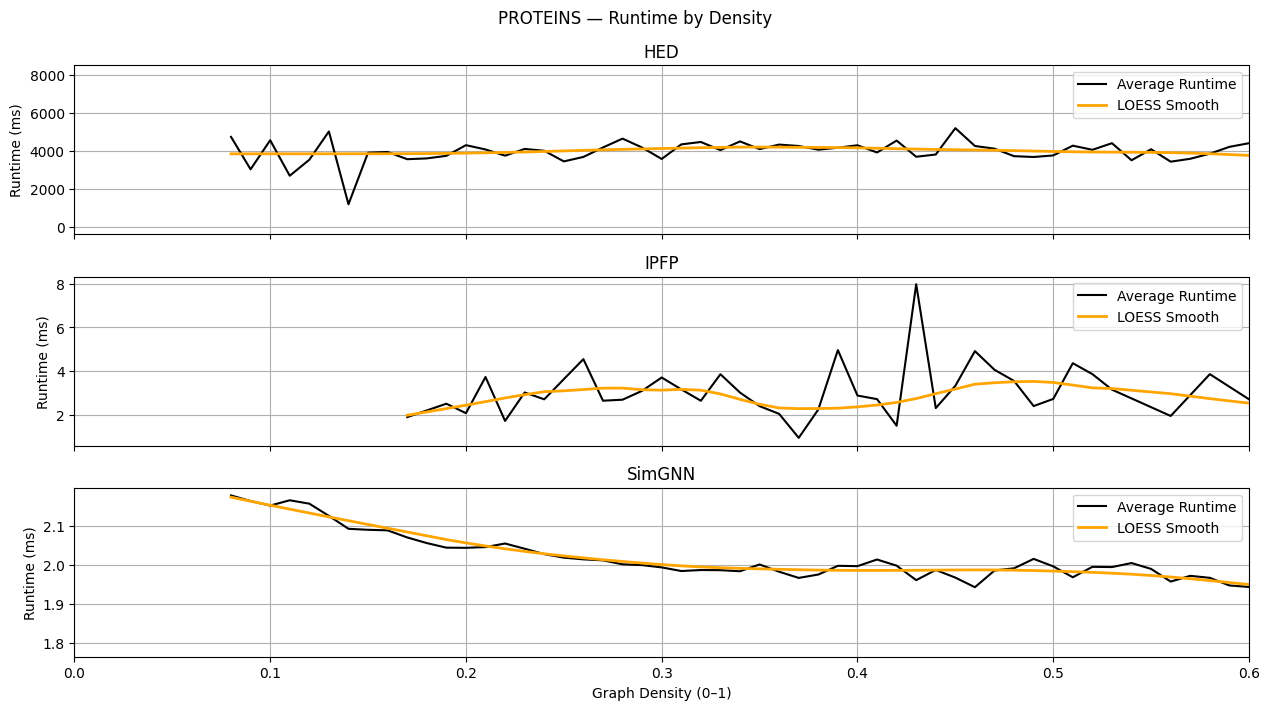

In [48]:
plot_runtime_by_density("AIDS")
plot_runtime_by_density("IMDB-BINARY")
plot_runtime_by_density("PROTEINS")